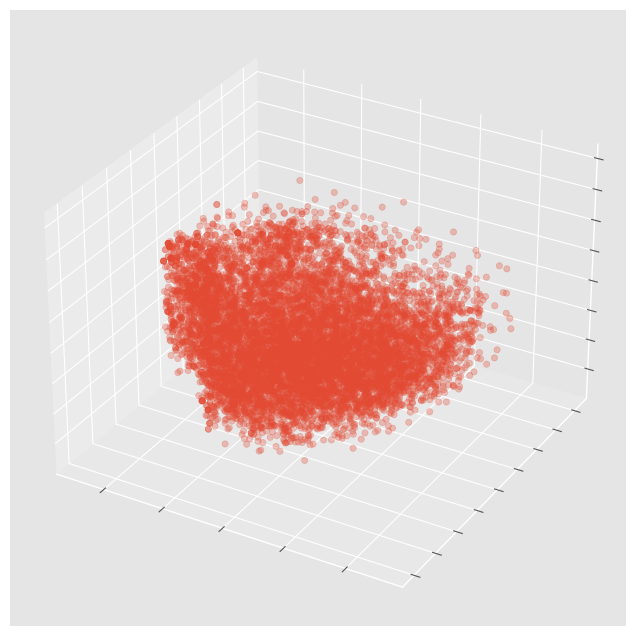

In [ ]:
# visualise embedding
svd = decomposition.TruncatedSVD(n_components=3)
pca_proj = svd.fit_transform(pca_embeddings)

x_plot = pca_proj[:, 0]
y_plot = pca_proj[:, 1]
z_plot = pca_proj[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

In [ ]:
# cluster
hdb = HDBSCAN(min_cluster_size=15,
              metric="euclidean",
              cluster_selection_method="eom")
hdb.fit(pca_embeddings)
cluster_labels = hdb.labels_

In [ ]:
def plot_clusters(embeddings, cluster_labels):
    svd = decomposition.TruncatedSVD(n_components=3)
    proj = svd.fit_transform(embeddings)

    outliers_proj = proj[cluster_labels == -1]
    clustered_proj = proj[cluster_labels != -1]
    clustered_labels = cluster_labels[cluster_labels != -1]

    x_plot_outliers = outliers_proj[:, 0]
    y_plot_outliers = outliers_proj[:, 1]
    z_plot_outliers = outliers_proj[:, 2]

    x_plot_clustered = clustered_proj[:, 0]
    y_plot_clustered = clustered_proj[:, 1]
    z_plot_clustered = clustered_proj[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    clustered_p = ax.scatter(x_plot_clustered,
                             y_plot_clustered,
                             z_plot_clustered,
                             c=clustered_labels,
                             alpha=0.3,
                             cmap="gist_rainbow")

    fig.colorbar(clustered_p)
    legend = ax.legend(*clustered_p.legend_elements(), title="Clusters")
    ax.add_artist(legend)

    plt.show()

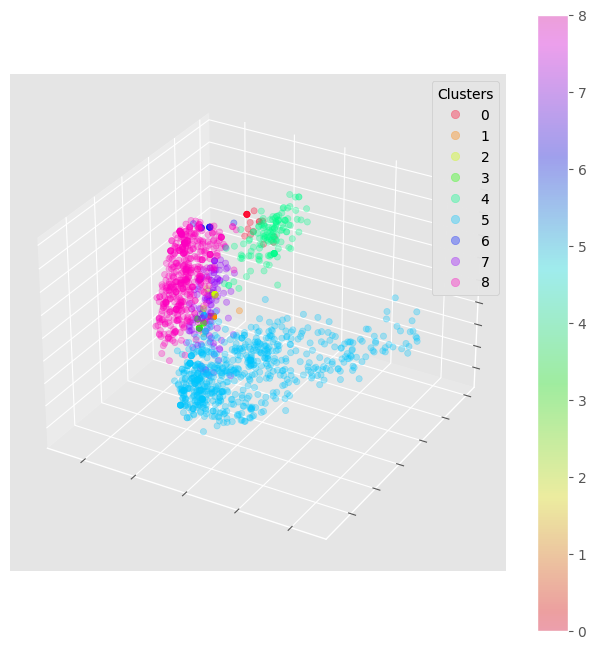

In [ ]:
plot_clusters(pca_embeddings, cluster_labels)

In [ ]:
# collate same clusters into 1 document
docs_df = pd.DataFrame({"Doc": course_rows})
docs_df['Topic'] = cluster_labels
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg(lambda x: " ".join([str(y) for y in x]))
docs_per_topic

,Topic,Doc
0,-1,charles great teacher ability explain concept ...
1,0,one best ever taken coursera one best ever don...
2,1,suitable beginner good introductory excellent ...
3,2,great beginner great true beginner great begin...
4,3,excellent beginner awesome beginner really goo...
5,4,really grateful prof charles severance fantast...
6,5,python_data_structures great great content gre...
7,6,best getting one best one best best best one b...
8,7,great informative easy understand remember qui...
9,8,good get familiar pretty good way wonderful li...


In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(course_rows))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=1):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
top_n_words

{-1: [('dr', 0.037165907928892135),
  ('chuck', 0.036770147143093526),
  ('great', 0.0359611838200361),
  ('good', 0.03263891305020536),
  ('really', 0.03242476108360064)],
 0: [('best', 1.4855593189023437),
  ('taken', 0.43823370473376505),
  ('participated', 0.2508661153556554),
  ('happen', 0.22850652888597975),
  ('seriously', 0.21045440669451448)],
 1: [('beginner', 1.2520738567675544),
  ('good', 0.6791954852261898),
  ('nice', 0.23791476848522125),
  ('suitable', 0.19276512646942515),
  ('introductory', 0.08729495700024702)],
 2: [('beginner', 1.2429678650819722),
  ('great', 0.6420587292612723),
  ('begineer', 0.13734010954020195),
  ('true', 0.11508964714707258),
  ('fantastic', 0.0776871783440628)],
 3: [('beginner', 1.1686022663163842),
  ('excellent', 0.5163705553147478),
  ('awesome', 0.23065686158581322),
  ('really', 0.20809456163317902),
  ('good', 0.198098683190972)],
 4: [('chuck', 0.3275619834037415),
  ('dr', 0.3218946219203514),
  ('thank', 0.1921202520694186),
  (

In [ ]:
def get_cluster_sizes(cluster_labels):
    cluster_df = pd.DataFrame({"cluster": cluster_labels, "size": course_rows})
    cluster_sizes = (cluster_df.groupby("cluster")
                        .count()
                        .reset_index())
    return cluster_sizes

In [ ]:
get_cluster_sizes(cluster_labels)

,cluster,size
0,-1,8039
1,0,19
2,1,30
3,2,27
4,3,16
5,4,134
6,5,664
7,6,16
8,7,126
9,8,467


In [ ]:
def get_cluster_sentiment(cluster_labels):
    cluster_df = pd.DataFrame({"cluster": cluster_labels, "sentiment": course_ratings})
    cluster_sentiment = (cluster_df.groupby("cluster")
                        .mean()
                        .reset_index())
    return cluster_sentiment

In [ ]:
get_cluster_sentiment(cluster_labels)

,cluster,sentiment
0,-1,0.99602
1,0,1.00000
2,1,1.00000
3,2,1.00000
4,3,1.00000
5,4,1.00000
6,5,1.00000
7,6,1.00000
8,7,1.00000
9,8,1.00000


### <a>6.2.2 HDBSCAN Clusterng with SBERT + UMAP Embedding</a>


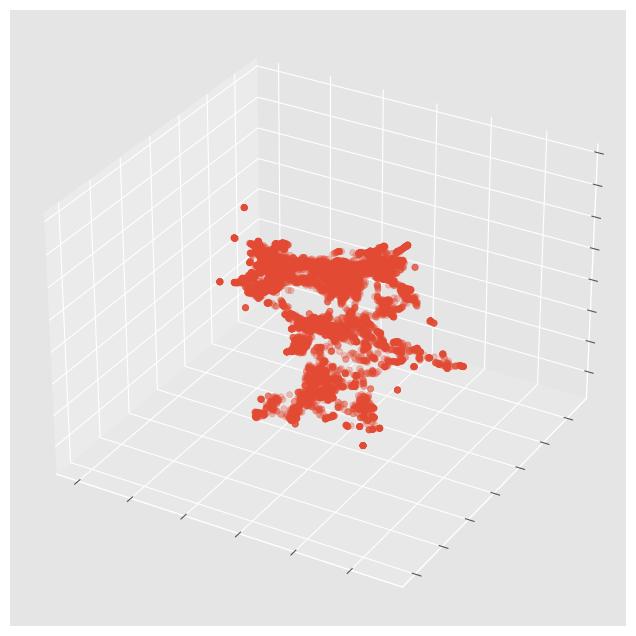

In [ ]:
# visualise embedding
svd = decomposition.TruncatedSVD(n_components=3)
pca_proj = svd.fit_transform(umap_embeddings)

x_plot = pca_proj[:, 0]
y_plot = pca_proj[:, 1]
z_plot = pca_proj[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

In [ ]:
# cluster
hdb = HDBSCAN(min_cluster_size=100,
              metric="euclidean",
              cluster_selection_method="eom")
hdb.fit(umap_embeddings)
cluster_labels = hdb.labels_

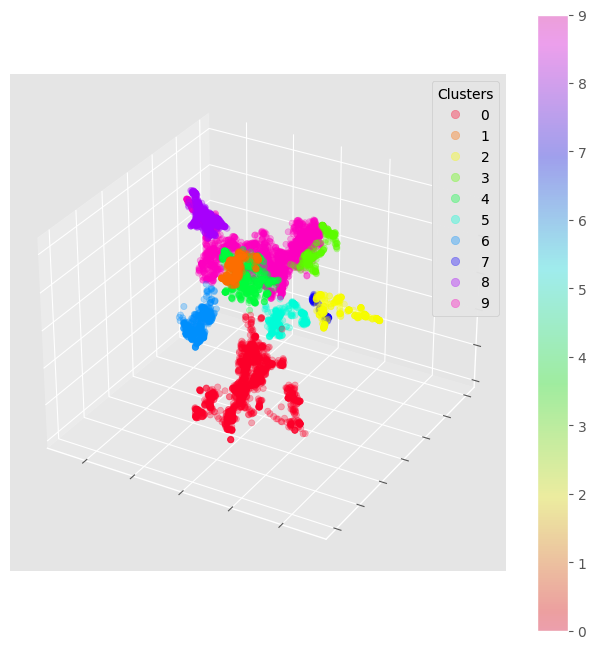

In [ ]:
plot_clusters(umap_embeddings, cluster_labels)

In [ ]:
# collate same clusters into 1 document
docs_df = pd.DataFrame({"Doc": course_rows})
docs_df['Topic'] = cluster_labels
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg(lambda x: " ".join([str(y) for y in x]))
docs_per_topic

,Topic,Doc
0,-1,python_data_structures great great content gre...
1,0,thank sir providing beautiful material nan gre...
2,1,easy one perfect beginner learning able unders...
3,2,amazing really good novice excellent like leve...
4,3,much text lot found non useful majority user c...
5,4,wonderful overall idea using lot help internet...
6,5,point view properly structured explained make ...
7,6,superb understood everything dr chuck taught w...
8,7,charles great teacher ability explain concept ...
9,8,excellent delivering good teaching enable stud...


In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(course_rows))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
top_n_words

{-1: [('great', 0.04974471842908813),
  ('best', 0.04903108897552918),
  ('good', 0.040164369126577476),
  ('dr', 0.039226069913319575),
  ('chuck', 0.03651972609883603)],
 0: [('good', 0.08965771496435931),
  ('great', 0.07265985158780157),
  ('really', 0.06362660972776472),
  ('thank', 0.05678493376219221),
  ('helpful', 0.0551380784571837)],
 1: [('easy', 0.3341860344870194),
  ('understand', 0.1552809258101513),
  ('follow', 0.13636315906059754),
  ('simple', 0.079538774272348),
  ('learn', 0.05276057219782213)],
 2: [('beginner', 0.6673744812885076),
  ('good', 0.13950079026234483),
  ('best', 0.09945010908481439),
  ('great', 0.0808699926168778),
  ('excellent', 0.06429995941657882)],
 3: [('challenging', 0.11985338562655848),
  ('bit', 0.07807850718794125),
  ('difficult', 0.07311654577323394),
  ('little', 0.05693444859606126),
  ('assignment', 0.05641335302602564)],
 4: [('learning', 0.13431188765334925),
  ('learn', 0.11284990242681071),
  ('great', 0.06381124555718976),
  ('

In [ ]:
get_cluster_sizes(cluster_labels)

,cluster,size
0,-1,2995
1,0,1465
2,1,418
3,2,310
4,3,262
5,4,595
6,5,300
7,6,448
8,7,129
9,8,466


In [ ]:
get_cluster_sentiment(cluster_labels)

,cluster,sentiment
0,-1,0.998664
1,0,0.999318
2,1,1.000000
3,2,1.000000
4,3,0.969466
5,4,1.000000
6,5,1.000000
7,6,1.000000
8,7,1.000000
9,8,1.000000


# Sentiment Analysis Group 1 (Topic Extraction)
## Table of Contents
1. Pre-Processing Data <br/>
2. Pre-Processing of Text Data </br>
3. Understanding Data </br>
4. Train Validation Test Split </br>
5. Embedding Features
  5.1 Word2Vec </br>
  5.2 Doc2Vec </br>
  5.3 SBERT + PCA </br>
  5.4 SBERT + UMAP </br>
6. Topic Extraction </br>
  6.1 K-Means Clustering </br>
    &ensp;6.1.1 K-Means Clustering with Word2Vec Embedding </br>
    &ensp;6.1.2 K-Means Clustering with Doc2Vec Embedding </br>
    &ensp;6.1.3 Conclusion </br>
  6.2 HDBSCAN </br>
    &ensp;6.2.1 HDBSCAN Clustering with SBERT + PCA Embedding </br>
    &ensp;6.2.2 HDBSCAN Clustering with SBERT + UMAP Embedding </br>
    &ensp;6.2.3 Conclusion </br>
  6.3 Aspect-Based Sentiment Analysis </br>
    &ensp;6.3.1 Course: Python Data Structures </br>
    &ensp;6.3.2 Course: The Data Scientist's Toolbox </br>

In [ ]:
! pip install langdetect -q
! pip install transformers -q
! pip install sentence-transformers -q
! pip install umap-learn -q
! pip install hdbscan -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... 

In [ ]:
import gdown

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import decomposition

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
from transformers import BertTokenizer, BertModel
from tokenizers import ByteLevelBPETokenizer
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.cluster import KMeans
from langdetect import detect
from scipy.sparse import csr_matrix
from textblob import TextBlob

import joblib

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import FastText

import re

import umap
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def download_from_gdrive(file_id, output_name):
  url = f'https://drive.google.com/uc?id={file_id}'
  output = output_name #with file type
  gdown.download(url, output, quiet=False)

# <a id="pre_processing_data">1. Pre-Processing Data</a>

In [ ]:
# Download the dataset
file_id = '1IQWdWR7JQFzI2tsNB8CLGgCWR9OkT_Tl' #https://drive.google.com/file/d/1IQWdWR7JQFzI2tsNB8CLGgCWR9OkT_Tl/view?usp=sharing
url = f'https://drive.google.com/uc?id={file_id}'
output = "course-reviews-web-scraped.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IQWdWR7JQFzI2tsNB8CLGgCWR9OkT_Tl
To: /content/course-reviews-web-scraped.csv
100%|██████████| 274M/274M [00:04<00:00, 57.7MB/s]


'course-reviews-web-scraped.csv'

In [ ]:
# read csv
df_ws = pd.read_csv("course-reviews-web-scraped.csv", sep=',')
df_ws.head()

<ipython-input-7-762abb8aa8bb>:2: DtypeWarning: Columns (0,1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ws = pd.read_csv("course-reviews-web-scraped.csv", sep=',')


,Unnamed: 0,star_ratings,review,reviewer,review_date,course_title,course_organization,course_rating,course_difficulty,course_review_estimate,course_duration,course_skills,course_URL
0,0,2.0,The labs did not require any code changes to c...,Nathan B,"Jul 15, 2023",Generative AI with Large Language Models,DeepLearning.AI,4.8,Intermediate,1200,1 - 4 Weeks,"Machine Learning, Natural Language Processing,...",/learn/generative-ai-with-llms
1,1,3.0,"Good overview of key topics, but the course is...",Ritvik I,"Jul 4, 2023",Generative AI with Large Language Models,DeepLearning.AI,4.8,Intermediate,1200,1 - 4 Weeks,"Machine Learning, Natural Language Processing,...",/learn/generative-ai-with-llms
2,2,1.0,The lectures define many important concepts in...,Cornelius G,"Jul 27, 2023",Generative AI with Large Language Models,DeepLearning.AI,4.8,Intermediate,1200,1 - 4 Weeks,"Machine Learning, Natural Language Processing,...",/learn/generative-ai-with-llms
3,3,4.0,It would have been better to have an opportuni...,Arman T,"Jul 23, 2023",Generative AI with Large Language Models,DeepLearning.AI,4.8,Intermediate,1200,1 - 4 Weeks,"Machine Learning, Natural Language Processing,...",/learn/generative-ai-with-llms
4,4,5.0,AWS and DeepLearning.AI structured the course ...,David S,"Sep 19, 2023",Generative AI with Large Language Models,DeepLearning.AI,4.8,Intermediate,1200,1 - 4 Weeks,"Machine Learning, Natural Language Processing,...",/learn/generative-ai-with-llms


In [ ]:
# only keep relevant columns
df_ws = df_ws.loc[:, ["course_title", "review", "star_ratings"]]
df_ws.head()

,course_title,review,star_ratings
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0


In [ ]:
print("Number of rows, before pre-processing:", len(df_ws))

Number of rows, before pre-processing: 700930


In [ ]:
# rows with empty values
df_ws.loc[df_ws.isna().any(axis=1)]

,course_title,review,star_ratings
2724,Foundations of Cybersecurity,NaN,5.0
2727,Foundations of Cybersecurity,NaN,5.0
2957,Foundations of Cybersecurity,NaN,4.0
3876,Prompt Engineering for ChatGPT,NaN,5.0
10736,Foundations of Digital Marketing and E-commerce,NaN,5.0
...,...,...,...
686260,Marketing e vendas B2B: Fechando novos negócios,NaN,5.0
689147,Becoming a changemaker: Introduction to Social...,NaN,5.0
689540,Building AI Applications with Watson APIs,NaN,4.0
690863,Blockchain Basics,NaN,5.0


In [ ]:
# drop rows with empty values
df_ws = df_ws.dropna().reset_index(drop=True)
df_ws.head()

,course_title,review,star_ratings
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0


In [ ]:
print("Number of rows, after removing rows with NA values:", len(df_ws))

Number of rows, after removing rows with NA values: 693362


In [ ]:
# convert string datatype to float (non-numeric values are converted to NA)
df_ws['star_ratings'] = pd.to_numeric(df_ws['star_ratings'], errors='coerce')
df_ws.head()

,course_title,review,star_ratings
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0


In [ ]:
# drop rows with empty values
df_ws = df_ws.dropna().reset_index(drop=True)
df_ws

,course_title,review,star_ratings
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0
...,...,...,...
693346,Fundamentals of financial and management accou...,The course has content which is not bad but no...,2.0
693347,Fundamentals of financial and management accou...,Watched the videos for the first week and trie...,2.0
693348,Fundamentals of financial and management accou...,really bad explainedim going to finish my bach...,1.0
693349,Fundamentals of financial and management accou...,Very poor teacher due to the language barrier....,1.0


In [ ]:
print("Number of rows, after converting star ratings to float and removing rows with NA values:", len(df_ws))

Number of rows, after converting star ratings to float and removing rows with NA values: 693351


In [ ]:
# convert ratings (from 1 to 5) to negative(0)/positive(1)
df_ws['rating_category'] = df_ws['star_ratings'].apply(lambda x: 0 if x <= 3 else 1)
df_ws.head()

,course_title,review,star_ratings,rating_category
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0,0
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0,0
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0,0
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0,1
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0,1


# <a id="pre_processing_of_taxt_data">2. Pre-Processing of Text Data</a>

- Remove Non-English Reviews

In [ ]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [ ]:
df_ws = df_ws[df_ws['review'].apply(is_english)]

In [ ]:
len(df_ws)

- Reviews with no pre-processing with lowercase

In [ ]:
# create a column with reviews in lowercase
df_ws.loc[:, "review_not_processed"] = df_ws.loc[:, "review"].str.lower()

- Remove Stopwords

In [ ]:
# get stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  # convert to lowercase
  text = text.lower()

  #replace all non-word characters (characters that are not a letter, digit, or underscore) in text with a space
  text = re.sub(r'\W', ' ', text)
  text = re.sub(r'\d', '', text)

  # split the text into individual words
  words = word_tokenize(text)

  # not to remove words like "no" and "not" because it affects the sentiment of the reviews
  words = [word for word in words if ((word not in stop_words) or (word in ["no", "not"]))]
  return ' '.join(words)

In [ ]:
# remove stopwords from reviews
df_ws.loc[:, "review_processed"] = df_ws.loc[:, "review"].apply(remove_stopwords)


- Lemmatize

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [ ]:
# lemmatize the reviews
df_ws.loc[:, "review_processed"] = df_ws.loc[:, "review_processed"].apply(lemmatize)

- Remove course title words

In [ ]:
from nltk.stem import PorterStemmer
def remove_course_topic(row):
  text = row["review_processed"]
  course_title = row["course_title"].lower()
  words = word_tokenize(text)
  course_title_words = word_tokenize(course_title)
  course_title_words_no_stopwords = [word for word in course_title_words if word not in stop_words]
  course_title_words_lemmatized = [lemmatizer.lemmatize(word) for word in course_title_words_no_stopwords]

  course_general_words = ["course"]

  words_to_remove = course_title_words_lemmatized + course_general_words

  words = [word for word in words if word not in words_to_remove]
  return ' '.join(words)

In [ ]:
# remove course topic words because those words are often used in the reviews, which can affect topic extraction
df_ws.loc[:, "review_processed_without_course_words"] = df_ws.apply(remove_course_topic, axis=1)

In [ ]:
# to save pre-processed df into csv
df_ws.to_csv("course-reviews-webscraped-processed-eng-lang.csv", sep=",")

In [ ]:
# to load pre-processed df
# Download the dataset
file_id = '1O2_ZEH7CPHXeKmFfnmr55SjRfrHrQc5w' #https://drive.google.com/file/d/1O2_ZEH7CPHXeKmFfnmr55SjRfrHrQc5w/view?usp=sharing
url = f'https://drive.google.com/uc?id={file_id}'
output = "course-reviews-webscraped-processed-eng-lang.csv"
gdown.download(url, output, quiet=False)

df_ws = pd.read_csv("course-reviews-webscraped-processed-eng-lang.csv", sep=',', index_col=False)
df_ws = df_ws.drop("Unnamed: 0", axis=1)
df_ws.head()

Downloading...
From: https://drive.google.com/uc?id=1O2_ZEH7CPHXeKmFfnmr55SjRfrHrQc5w
To: /content/course-reviews-webscraped-processed-eng-lang.csv
100%|██████████| 274M/274M [00:02<00:00, 122MB/s]


,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words
0,Generative AI with Large Language Models,The labs did not require any code changes to c...,2.0,0,the labs did not require any code changes to c...,lab not require code change complete similar f...,lab not require code change complete similar f...
1,Generative AI with Large Language Models,"Good overview of key topics, but the course is...",3.0,0,"good overview of key topics, but the course is...",good overview key topic course practical would...,good overview key topic practical would hoped ...
2,Generative AI with Large Language Models,The lectures define many important concepts in...,1.0,0,the lectures define many important concepts in...,lecture define many important concept easy und...,lecture define many important concept easy und...
3,Generative AI with Large Language Models,It would have been better to have an opportuni...,4.0,1,it would have been better to have an opportuni...,would better opportunity write code assignment...,would better opportunity write code assignment...
4,Generative AI with Large Language Models,AWS and DeepLearning.AI structured the course ...,5.0,1,aws and deeplearning.ai structured the course ...,aws deeplearning ai structured course three co...,aws deeplearning structured three comprehensiv...


In [ ]:
# separate features & target
X = df_ws[["course_title", "review_not_processed", "review_processed", "review_processed_without_course_words"]]
y = df_ws.loc[:, "rating_category"]
y_with_course_title = df_ws.loc[:, ["course_title", "rating_category"]]

In [ ]:
X_review = X.loc[:, "review_processed_without_course_words"]

# <a id="sentiment_prediction">3. Understanding Data</a>

In [ ]:
df_ws['rating_category'].value_counts()

1    498443
0     40114
Name: rating_category, dtype: int64

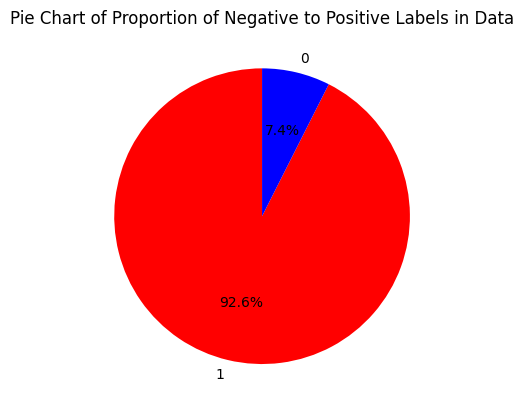

In [ ]:
plt.pie(df_ws['rating_category'].value_counts(), labels=df_ws['rating_category'].value_counts().index, autopct='%1.1f%%', colors=['red', 'blue'], startangle=90)

plt.title('Pie Chart of Proportion of Negative to Positive Labels in Data')

plt.show()

# <a id="sentiment_prediction">4. Train Validation Test Split</a>

In [ ]:
# separate features & target
X = df_ws[["course_title", "review_not_processed", "review_processed", "review_processed_without_course_words"]]
y = df_ws.loc[:, "rating_category"]
y_with_course_title = df_ws.loc[:, ["course_title", "rating_category"]]

In [ ]:
# train validation test split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_val_index, test_index in sss.split(X, y):
  X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, valid_index in sss.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[valid_index]

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

263892
113097
161568


In [ ]:
df_ws['rating_category'].value_counts()

1    498443
0     40114
Name: rating_category, dtype: int64

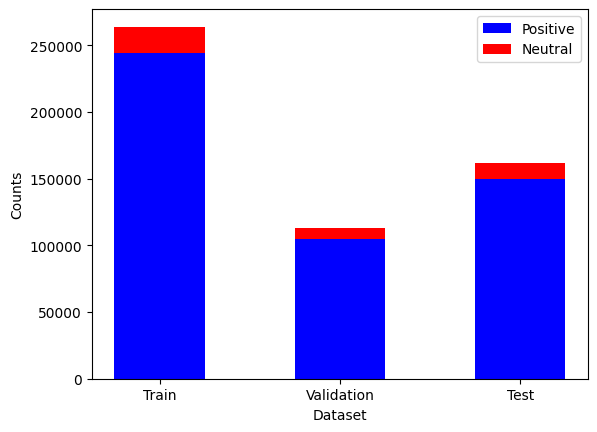

In [ ]:
# plot count of positive vs negative reviews (significant imbalance)
labels = ['Train', 'Validation', 'Test']
positive_counts = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]
negative_counts = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots()
bar1 = ax.bar(x, positive_counts, width, label='Positive', color='blue')
bar2 = ax.bar(x, negative_counts, width, label='Neutral', bottom=positive_counts, color='red')

ax.set_ylabel('Counts')
ax.set_xlabel('Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# <a id="sentiment_prediction">5. Embedding Features </a>

In [ ]:
X_review_not_processed = X.loc[:, "review_not_processed"]
X_review_processed = X.loc[:, "review_processed"]
X_review = X.loc[:, "review_processed_without_course_words"]

### <a id="sentiment_prediction">5.1 Word2Vec</a>

In [ ]:
def tokenize_text(text):
  if isinstance(text, (str, bytes)):
    return word_tokenize(text.lower())
  else:
    return []

In [ ]:
X_review_tokenized = X_review.apply(tokenize_text)

In [ ]:
w2v_model = Word2Vec(X_review_tokenized, vector_size=50, window=5, min_count=1, workers=4)

In [ ]:
# to save model
# joblib.dump(w2v_model, 'KMEANS-w2v.joblib')

In [ ]:
# to load presaved model
download_from_gdrive("14DjI7xd2s0EmrtLPY7fKYf7OMFmK-aey", "KMEANS-w2v.joblib")
w2v_model = joblib.load('KMEANS-w2v.joblib')

Downloading...
From: https://drive.google.com/uc?id=14DjI7xd2s0EmrtLPY7fKYf7OMFmK-aey
To: /content/KMEANS-w2v.joblib
100%|██████████| 31.7M/31.7M [00:00<00:00, 146MB/s]


In [ ]:
wv = w2v_model.wv

In [ ]:
# vectorizing documents by averaging word embeddings
def document_vectorizer(doc, model):
  if isinstance(doc, (csr_matrix, float)):
    return np.zeros(model.vector_size)

  # filter out words that are not in the model's vocabulary
  words = [word for word in doc if word in model.wv.key_to_index]

  # return the mean of the word vectors
  if words:
    return np.mean(model.wv[words], axis=0)
  else:
    return np.zeros(model.vector_size)

In [ ]:
# apply the vectorizer to each document in the corpus
X_review_w2v = [document_vectorizer(doc, w2v_model) for doc in X_review]

### <a id="sentiment_prediction">5.2 Doc2Vec</a>

In [ ]:
tagged_data = [TaggedDocument(words=tokenize_text(text), tags=[str(i)]) for i, text in enumerate(X_review)]

# train doc2vec model on training data
doc2vec = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=20)
doc2vec.build_vocab(tagged_data)
doc2vec.train(tagged_data, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# encode reviews using trained doc2vec model
X_reviews_d2v = [doc2vec.infer_vector(doc.words) for doc in tagged_data]

### 5.3 SBERT + PCA

In [ ]:
# get courses with most number of reviews
X.groupby("course_title")["review_processed_without_course_words"].count().reset_index().sort_values("review_processed_without_course_words", ascending=False).head(10)

,course_title,review_processed_without_course_words
131,COVID-19 Contact Tracing,9613
770,Python Data Structures,9538
176,Crash Course on Python,7582
451,Indigenous Canada,7242
832,Stanford Introduction to Food and Health,6894
922,Using Python to Access Web Data,6592
561,Introduction to Psychology,6387
446,Improving Deep Neural Networks: Hyperparameter...,6087
867,The Data Scientist’s Toolbox,5991
411,Google Cloud Fundamentals: Core Infrastructure,5907


In [ ]:
# choose a course to cluster
course_title = "Python Data Structures"

# get index of review rows that belong to this course
course_rows = X_review[X['course_title'] == course_title].copy()
course_rows = course_rows.reset_index(drop=True)

# get rating
course_ratings = df_ws["rating_category"][X['course_title'] == course_title].copy()
course_ratings = course_ratings.reset_index(drop=True)

In [ ]:
# pre-trained SBERT
sbert_encoder = SentenceTransformer('distilbert-base-nli-mean-tokens')
sbert_embeddings = sbert_encoder.encode(course_rows, show_progress_bar=True)

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
# PCA dimension reduction
pca = decomposition.PCA(n_components=10)
pca.fit(sbert_embeddings)

PCA(n_components=10)

Text(0.5, 1.0, 'Scree Plot')

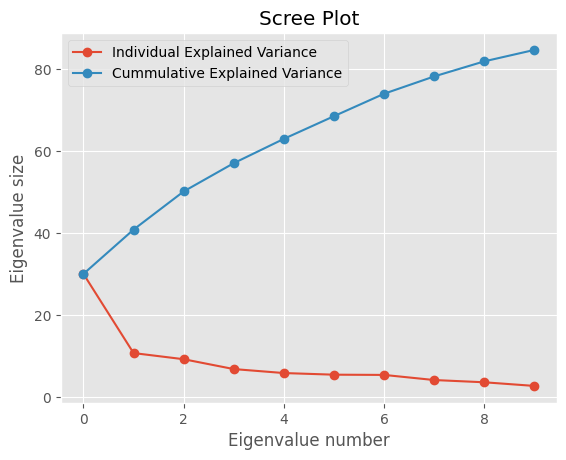

In [ ]:
# use a scree plot to find the right dimension reduction
plt.style.use("ggplot")
plt.plot(pca.explained_variance_, marker='o', label="Individual Explained Variance")
plt.plot(np.cumsum(pca.explained_variance_), marker='o', label="Cummulative Explained Variance")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.legend()
plt.title("Scree Plot")

In [ ]:
cutoff = 80

cummulative_explained_var = np.cumsum(pca.explained_variance_)
reach_cutoff = cummulative_explained_var >= cutoff
ideal_pca_n_components = np.argmax(reach_cutoff) + 1

In [ ]:
pca = decomposition.PCA(n_components=ideal_pca_n_components)
pca_embeddings = pca.fit_transform(sbert_embeddings)

### 5.4 SBERT + UMAP

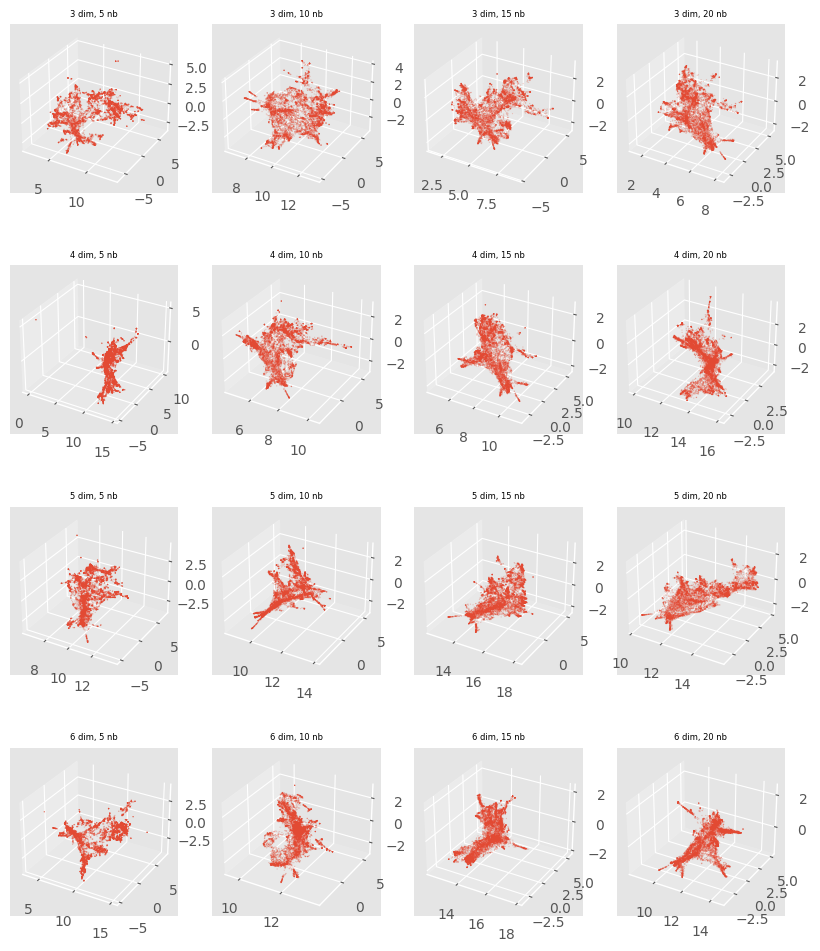

In [ ]:
# Visualising best UMAP reduction
fig, axs = plt.subplots(4, 4, figsize=(10, 12), subplot_kw=dict(projection="3d"))

for i, n_dimensions in enumerate(range(3, 7)):
    for j, n_neighbors in enumerate([5, 10, 15, 20]):
        umap_embeddings = umap.UMAP(n_neighbors=n_neighbors,
                            n_components=n_dimensions,
                            min_dist=0.0,
                            metric='cosine').fit_transform(sbert_embeddings)
        svd = decomposition.TruncatedSVD(n_components=3)
        umap_proj = svd.fit_transform(umap_embeddings)

        x_plot = umap_proj[:, 0]
        y_plot = umap_proj[:, 1]
        z_plot = umap_proj[:, 2]

        axs[i, j].scatter(x_plot, y_plot, z_plot, alpha=0.2, s=0.2)
        axs[i, j].set_title("{0} dim, {1} nb".format(n_dimensions, n_neighbors), size=6)

plt.show()

In [ ]:
# Ideal UMAP dimension reduction
n_dimensions = 4
umap_embeddings = umap.UMAP(n_neighbors=5,
                            n_components=n_dimensions,
                            min_dist=0.0,
                            metric='cosine').fit_transform(sbert_embeddings)

# <a id="sentiment_prediction">6. Topic Extraction</a>

## <a id="sentiment_prediction">6.1 K-Means Clustering</a>


- Choose a course to cluster

In [ ]:
# get courses with most number of reviews
X.groupby("course_title")["review_processed_without_course_words"].count().reset_index().sort_values("review_processed_without_course_words", ascending=False).head(10)

,course_title,review_processed_without_course_words
131,COVID-19 Contact Tracing,9613
770,Python Data Structures,9538
176,Crash Course on Python,7582
451,Indigenous Canada,7242
832,Stanford Introduction to Food and Health,6894
922,Using Python to Access Web Data,6592
561,Introduction to Psychology,6387
446,Improving Deep Neural Networks: Hyperparameter...,6087
867,The Data Scientist’s Toolbox,5991
411,Google Cloud Fundamentals: Core Infrastructure,5907


In [ ]:
# choose a course to cluster
course_title = "Python Data Structures"

# get index of review rows that belong to this course
course_row_indices = X[X['course_title'] == course_title].index.values

In [ ]:
course_row_indices_negative = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 0)].index.values
course_row_indices_positive = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 1)].index.values

#### <a id="sentiment_prediction">6.1.1 K-Means Clustering with Word2Vec Embedding</a>

- Get data for chosen course

In [ ]:
X_review_w2v_for_course = [X_review_w2v[i] for i in course_row_indices]

In [ ]:
X_review_w2v_for_course_negative = [X_review_w2v[i] for i in course_row_indices_negative]
X_review_w2v_for_course_positive = [X_review_w2v[i] for i in course_row_indices_positive]

- Find best number of clusters

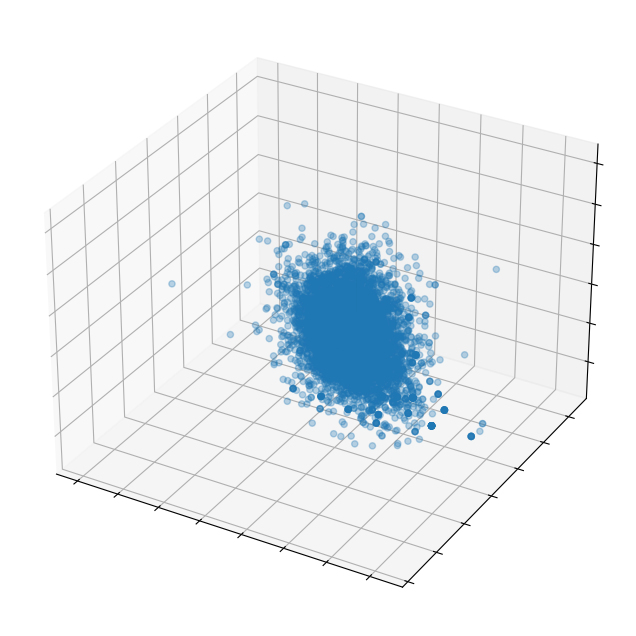

In [ ]:
svd = decomposition.TruncatedSVD(n_components=3)
W1_dec = svd.fit_transform(X_review_w2v_for_course)

x_plot = W1_dec[:, 0]
y_plot = W1_dec[:, 1]
z_plot = W1_dec[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

Optimal Number of Clusters (based on silhouette score): 2


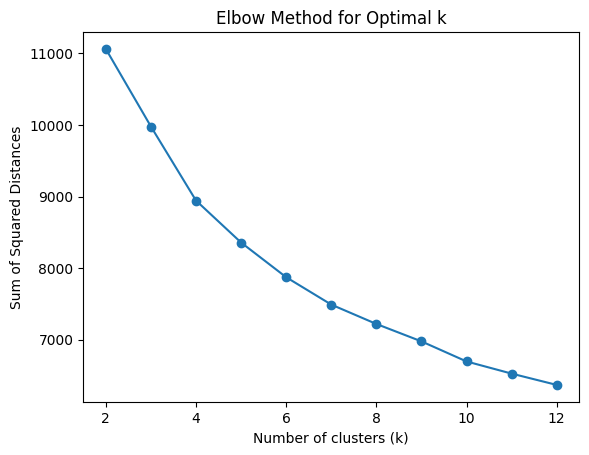

In [ ]:
from sklearn.metrics import silhouette_score
k_values = range(2,13)
inertia = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_review_w2v_for_course)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_review_w2v_for_course, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Find the k with the highest silhouette score
optimal_num_clusters = k_values[np.argmax(silhouette_scores)]
print("Optimal Number of Clusters (based on silhouette score):", optimal_num_clusters)

# Plot the Elbow graph
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

- Perform clustering based on chosen number of clusters

In [ ]:
# Perform K-means clustering
k = 4  # Number of clusters (chosen using elbow method)
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
kmeans.fit(X_review_w2v_for_course)

KMeans(n_clusters=4, n_init='auto', random_state=0)

- Find the top words in each cluster

In [ ]:
cluster_labels = kmeans.predict(X_review_w2v_for_course)

# create an empty dictionary to store word vectors for each cluster
cluster_word_vectors = {i: [] for i in range(k)}

# iterate over each review in the selected course and add its word vectors to the corresponding cluster
for i, review_vector in enumerate(X_review_w2v_for_course):
    cluster_word_vectors[cluster_labels[i]].append(review_vector)

# get centroids of each cluster
cluster_centroids = {cluster: np.mean(word_vectors, axis=0) for cluster, word_vectors in cluster_word_vectors.items()}

# get top 10 words for each cluster based on cosine similarity with the cluster centroid
top_words_per_cluster = {}
for cluster, centroid in cluster_centroids.items():
    # calculate cosine similarity between each word vector and the cluster centroid
    similarities = cosine_similarity(np.array(centroid).reshape(1, -1), np.array(cluster_word_vectors[cluster]))

    # get the indices of the top 10 words based on cosine similarity
    top_word_indices = np.argsort(similarities[0])[-10:][::-1]

    # get the actual words using the indices
    top_words = [wv.index_to_key[index] for index in top_word_indices]

    top_words_per_cluster[cluster] = top_words

# print top words for each cluster
for cluster, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster + 1} Top Words: {top_words}")

Cluster 1 Top Words: ['loved', 'fantastic', 'well', 'developed', 'taking', 'look', 'term', 'lot', 'clear', 'career']
Cluster 2 Top Words: ['teach', 'instructor', 'pretty', 'required', 'would', 'thing', 'introduction', 'recommend', 'subject', 'get']
Cluster 3 Top Words: ['principle', 'complete', 'level', 'lecture', 'opinion', 'quiz', 'provide', 'clear', 'field', 'little']
Cluster 4 Top Words: ['understandable', 'professor', 'complete', 'research', 'helped', 'science', 'commerce', 'made', 'already', 'took']


Cluster 1 has 1527 entries
Cluster 2 has 2300 entries
Cluster 3 has 1500 entries
Cluster 4 has 4212 entries


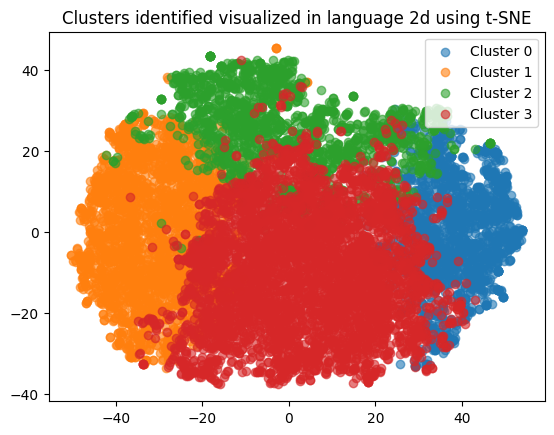

In [ ]:
reviews_for_course_title = X.loc[X["course_title"] == course_title].reset_index(drop=True)
reviews_for_course_title["cluster_id"] = kmeans.labels_


# visualize the clustering on a 2-d plot

tsne = TSNE(n_components=2, perplexity=100, random_state=42, init="pca")
vis_dims2 = tsne.fit_transform(np.array(X_review_w2v_for_course))

color_bank = list(matplotlib.colors.TABLEAU_COLORS.values())
colors = color_bank [:k]

x_plot = [x_plot for x_plot, y_plot in vis_dims2]
y_plot = [y_plot for x_plot, y_plot in vis_dims2]

for category, color in enumerate(colors):
    print('Cluster %d has %d entries' %(category+1, np.sum(reviews_for_course_title.cluster_id == category)))
    xs = np.array(x_plot)[reviews_for_course_title.cluster_id == category]
    ys = np.array(y_plot)[reviews_for_course_title.cluster_id == category]
    plt.scatter(xs, ys, color=color, alpha=0.6, label = 'Cluster %d' %category)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", c=color, s=300)

plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.legend()

- Find the percentage of positive reviews in cluster

In [ ]:
cluster_indices = [np.where(cluster_labels == i)[0] for i in range(k)]

labels_for_course_title = y_with_course_title.loc[y_with_course_title["course_title"] == course_title].reset_index(drop=True)

for cluster_id in range(k):
  labels_per_cluster = labels_for_course_title.loc[cluster_indices[cluster_id], "rating_category"]


  print(f"Cluster {cluster_id + 1}:")
  print("Actual # of +ve reviews in cluster / Total # of reviews in cluster:", np.sum(labels_per_cluster) / len(labels_per_cluster))

Cluster 1:
Actual # of +ve reviews in cluster / Total # of reviews in cluster: 0.9993451211525868
Cluster 2:
Actual # of +ve reviews in cluster / Total # of reviews in cluster: 0.9965217391304347
Cluster 3:
Actual # of +ve reviews in cluster / Total # of reviews in cluster: 1.0
Cluster 4:
Actual # of +ve reviews in cluster / Total # of reviews in cluster: 0.9945394112060779


#### <a id="sentiment_prediction">6.1.2 K-Means Clustering with Doc2Vec Embedding</a>

- Get data for chosen course

In [ ]:
X_review_d2v_for_course = [X_reviews_d2v[i] for i in course_row_indices]

In [ ]:
X_review_d2v_for_course_negative = [X_reviews_d2v[i] for i in course_row_indices_negative]
X_review_d2v_for_course_positive = [X_reviews_d2v[i] for i in course_row_indices_positive]

- Find best number of clusters



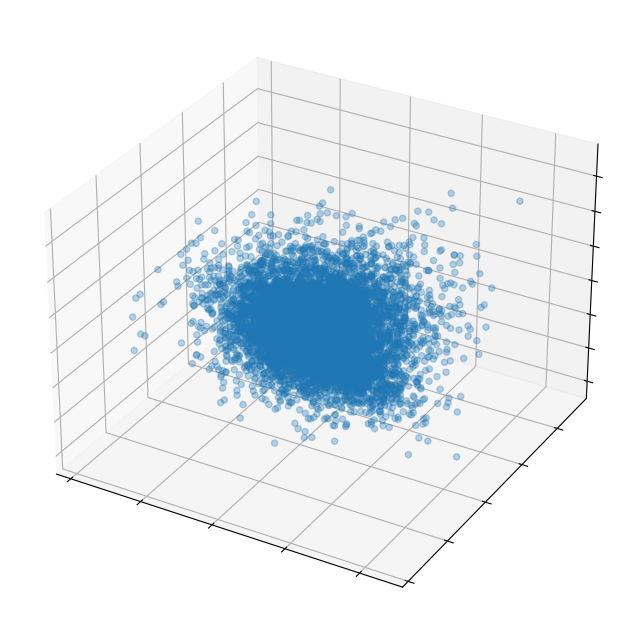

In [ ]:
svd = decomposition.TruncatedSVD(n_components=3)
W1_dec = svd.fit_transform(X_review_d2v_for_course)

x_plot = W1_dec[:, 0]
y_plot = W1_dec[:, 1]
z_plot = W1_dec[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

Optimal Number of Clusters (based on silhouette score): 2


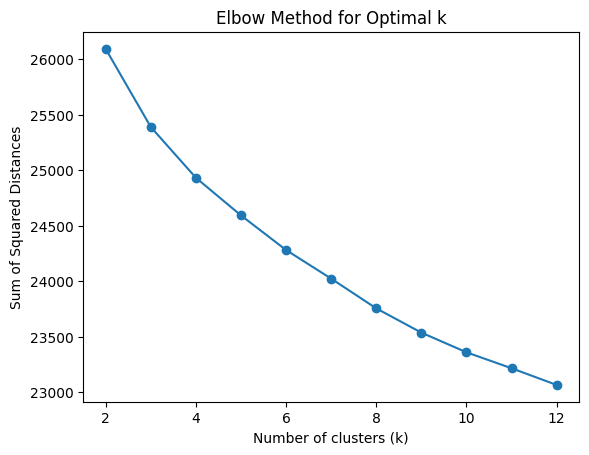

In [ ]:
from sklearn.metrics import silhouette_score
k_values = range(2,13)
inertia = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_review_d2v_for_course)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_review_d2v_for_course, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Find the k with the highest silhouette score
optimal_num_clusters = k_values[np.argmax(silhouette_scores)]
print("Optimal Number of Clusters (based on silhouette score):", optimal_num_clusters)

# Plot the Elbow graph
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

- Perform clustering based on chosen number of clusters

In [ ]:
# Perform K-means clustering
k = 5  # Number of clusters (based on elbow method)
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
kmeans.fit(X_review_d2v_for_course)

KMeans(n_clusters=5, n_init='auto', random_state=0)

- Find the top words in each cluster

In [ ]:
clusters = kmeans.fit_predict(X_review_d2v_for_course)

# find centroid of each cluster
cluster_centroids = []
for i in range(kmeans.n_clusters):
    cluster_docs = np.array(X_review_d2v_for_course)[clusters == i]
    centroid = np.mean(cluster_docs, axis=0)
    cluster_centroids.append(centroid)

# find top words associated with each centroid using cosine similarity
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(X_review.dropna())

# print top words for each cluster
for i, centroid in enumerate(cluster_centroids):
    similarity_scores = cosine_similarity([centroid], X_review_d2v_for_course)
    top_doc_indices = np.argsort(similarity_scores[0])[::-1][:5]
    top_words = [word for word in tokenize_text(X_review.iloc[top_doc_indices[0]]) if word.isalpha()]
    print(f"Cluster {i+1} - Top words: {', '.join(top_words)}")

Cluster 1 - Top words: awesome, excited, share, first, ai, beginner, friendly, actually, boosted, interest, ai, ml, happy, satisfied
Cluster 2 - Top words: fantastic, beginner
Cluster 3 - Top words: overall, experience, awesome
Cluster 4 - Top words: complete, insightful, introduction, thei, certificate, joi, amazing, instructor, topic, well, organized, learning, feel, progressive, interesting
Cluster 5 - Top words: not, bad, beginner


Cluster 1 has 1590 entries
Cluster 2 has 2403 entries
Cluster 3 has 2844 entries
Cluster 4 has 1051 entries
Cluster 5 has 1651 entries


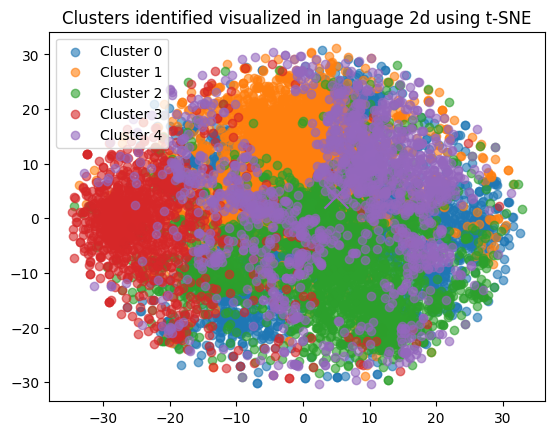

In [ ]:
reviews_for_course_title = X.loc[X["course_title"] == course_title].reset_index(drop=True)
reviews_for_course_title["cluster_id"] = kmeans.labels_


# Visualize the clustering on a 2-d plot

tsne = TSNE(n_components=2, perplexity=100, random_state=42, init="pca")
vis_dims2 = tsne.fit_transform(np.array(X_review_d2v_for_course))

color_bank = list(matplotlib.colors.TABLEAU_COLORS.values())
colors = color_bank [:k]

x_plot = [x_plot for x_plot, y_plot in vis_dims2]
y_plot = [y_plot for x_plot, y_plot in vis_dims2]

for category, color in enumerate(colors):
    print('Cluster %d has %d entries' %(category+1, np.sum(reviews_for_course_title.cluster_id == category)))
    xs = np.array(x_plot)[reviews_for_course_title.cluster_id == category]
    ys = np.array(y_plot)[reviews_for_course_title.cluster_id == category]
    plt.scatter(xs, ys, color=color, alpha=0.6, label = 'Cluster %d' %category)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", c=color, s=300)

plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.legend()

- Find the percentage of positive reviews in cluster

In [ ]:
cluster_indices = [np.where(cluster_labels == i)[0] for i in range(k)]

labels_for_course_title = y_with_course_title.loc[y_with_course_title["course_title"] == course_title].reset_index(drop=True)

for cluster_id in range(k):
  labels_per_cluster = labels_for_course_title.loc[cluster_indices[cluster_id], "rating_category"]

  print(f"Cluster {cluster_id + 1}:")
  print("Actual # of +ve reviews in cluster / Total # of reviews in cluster:", np.sum(labels_per_cluster) / len(labels_per_cluster))

#### <a id="sentiment_prediction">6.1.3 Conclusion</a>

Based on the results, doing K-means clustering using both embedding methods, Word2Vec and Doc2Vec, both result in clusters with unclear topics. The main topics of each cluster is difficult to tell from the top words, making it difficult to identify the relevant topics mentioned in the reviews. This may be due to the fact that K-means is a more simple model for cluster, which makes it less capable with clustering of text data with semantics in mind. The amount of data available may also not be suitable for K-means clustering when the number of dimensions are high.

Furthermore, identifying the sentiment within each cluster is also difficult as there is a significant imbalance of data, with the large majority being positive reviews. Therefore, just looking at the number of samples for each label compared to the total number of samples will most likely result in  positive sentiments for all clusters.

Hence, aspect-based sentiment analysis may work better in identifying the topics for groups of related topics/aspect. This has been done by using LDA for topic extraction, finding the similarity between the review and each topic, then predicting the review's sentiment for each aspect using a model that has been trained using undersampled data and aggregating the results to get the sentiment for each aspect for all reviews. This solves the issues regarding unclear topics and imbalanced data

## <a id="sentiment_prediction">6.2 HDBSCAN</a>

### <a>6.2.1 HDBSCAN Clustering with SBERT + PCA Embedding</a>

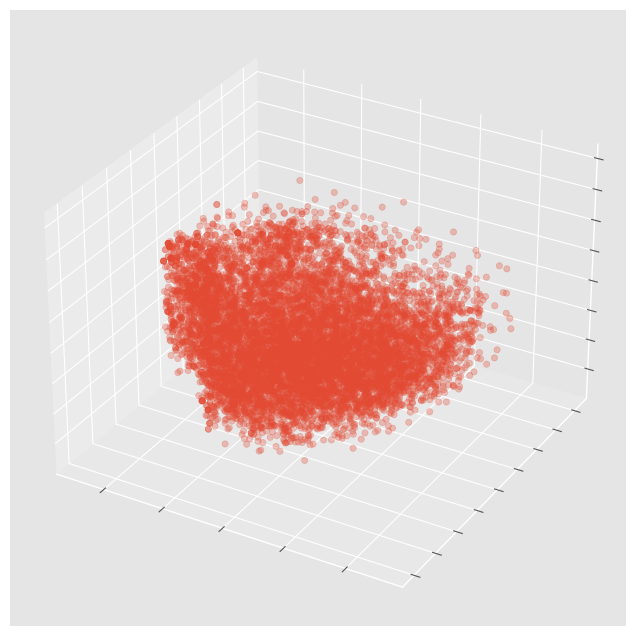

In [ ]:
# visualise embedding
svd = decomposition.TruncatedSVD(n_components=3)
pca_proj = svd.fit_transform(pca_embeddings)

x_plot = pca_proj[:, 0]
y_plot = pca_proj[:, 1]
z_plot = pca_proj[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

In [ ]:
# cluster
hdb = HDBSCAN(min_cluster_size=15,
              metric="euclidean",
              cluster_selection_method="eom")
hdb.fit(pca_embeddings)
cluster_labels = hdb.labels_

In [ ]:
def plot_clusters(embeddings, cluster_labels):
    svd = decomposition.TruncatedSVD(n_components=3)
    proj = svd.fit_transform(embeddings)

    outliers_proj = proj[cluster_labels == -1]
    clustered_proj = proj[cluster_labels != -1]
    clustered_labels = cluster_labels[cluster_labels != -1]

    x_plot_outliers = outliers_proj[:, 0]
    y_plot_outliers = outliers_proj[:, 1]
    z_plot_outliers = outliers_proj[:, 2]

    x_plot_clustered = clustered_proj[:, 0]
    y_plot_clustered = clustered_proj[:, 1]
    z_plot_clustered = clustered_proj[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    clustered_p = ax.scatter(x_plot_clustered,
                             y_plot_clustered,
                             z_plot_clustered,
                             c=clustered_labels,
                             alpha=0.3,
                             cmap="gist_rainbow")

    fig.colorbar(clustered_p)
    legend = ax.legend(*clustered_p.legend_elements(), title="Clusters")
    ax.add_artist(legend)

    plt.show()

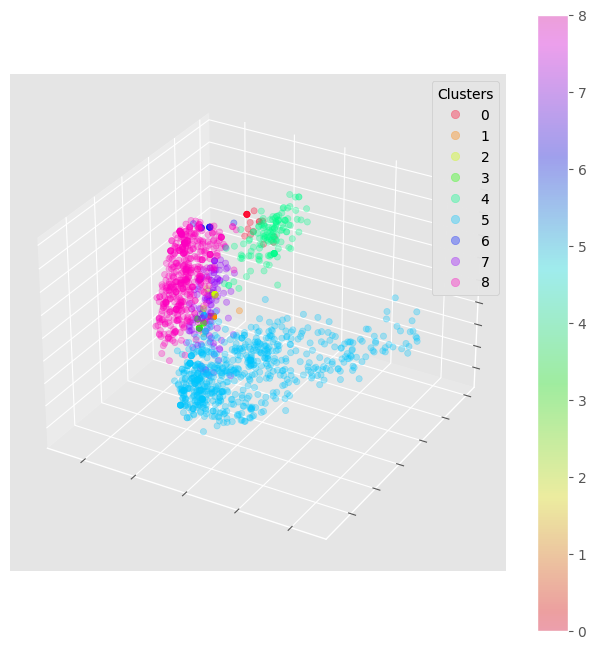

In [ ]:
plot_clusters(pca_embeddings, cluster_labels)

In [ ]:
# collate same clusters into 1 document
docs_df = pd.DataFrame({"Doc": course_rows})
docs_df['Topic'] = cluster_labels
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg(lambda x: " ".join([str(y) for y in x]))
docs_per_topic

,Topic,Doc
0,-1,charles great teacher ability explain concept ...
1,0,one best ever taken coursera one best ever don...
2,1,suitable beginner good introductory excellent ...
3,2,great beginner great true beginner great begin...
4,3,excellent beginner awesome beginner really goo...
5,4,really grateful prof charles severance fantast...
6,5,python_data_structures great great content gre...
7,6,best getting one best one best best best one b...
8,7,great informative easy understand remember qui...
9,8,good get familiar pretty good way wonderful li...


In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(course_rows))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=1):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
top_n_words

{-1: [('dr', 0.037165907928892135),
  ('chuck', 0.036770147143093526),
  ('great', 0.0359611838200361),
  ('good', 0.03263891305020536),
  ('really', 0.03242476108360064)],
 0: [('best', 1.4855593189023437),
  ('taken', 0.43823370473376505),
  ('participated', 0.2508661153556554),
  ('happen', 0.22850652888597975),
  ('seriously', 0.21045440669451448)],
 1: [('beginner', 1.2520738567675544),
  ('good', 0.6791954852261898),
  ('nice', 0.23791476848522125),
  ('suitable', 0.19276512646942515),
  ('introductory', 0.08729495700024702)],
 2: [('beginner', 1.2429678650819722),
  ('great', 0.6420587292612723),
  ('begineer', 0.13734010954020195),
  ('true', 0.11508964714707258),
  ('fantastic', 0.0776871783440628)],
 3: [('beginner', 1.1686022663163842),
  ('excellent', 0.5163705553147478),
  ('awesome', 0.23065686158581322),
  ('really', 0.20809456163317902),
  ('good', 0.198098683190972)],
 4: [('chuck', 0.3275619834037415),
  ('dr', 0.3218946219203514),
  ('thank', 0.1921202520694186),
  (

In [ ]:
def get_cluster_sizes(cluster_labels):
    cluster_df = pd.DataFrame({"cluster": cluster_labels, "size": course_rows})
    cluster_sizes = (cluster_df.groupby("cluster")
                        .count()
                        .reset_index())
    return cluster_sizes

In [ ]:
get_cluster_sizes(cluster_labels)

,cluster,size
0,-1,8039
1,0,19
2,1,30
3,2,27
4,3,16
5,4,134
6,5,664
7,6,16
8,7,126
9,8,467


In [ ]:
def get_cluster_sentiment(cluster_labels):
    cluster_df = pd.DataFrame({"cluster": cluster_labels, "sentiment": course_ratings})
    cluster_sentiment = (cluster_df.groupby("cluster")
                        .mean()
                        .reset_index())
    return cluster_sentiment

In [ ]:
get_cluster_sentiment(cluster_labels)

,cluster,sentiment
0,-1,0.99602
1,0,1.00000
2,1,1.00000
3,2,1.00000
4,3,1.00000
5,4,1.00000
6,5,1.00000
7,6,1.00000
8,7,1.00000
9,8,1.00000


### <a>6.2.2 HDBSCAN Clusterng with SBERT + UMAP Embedding</a>


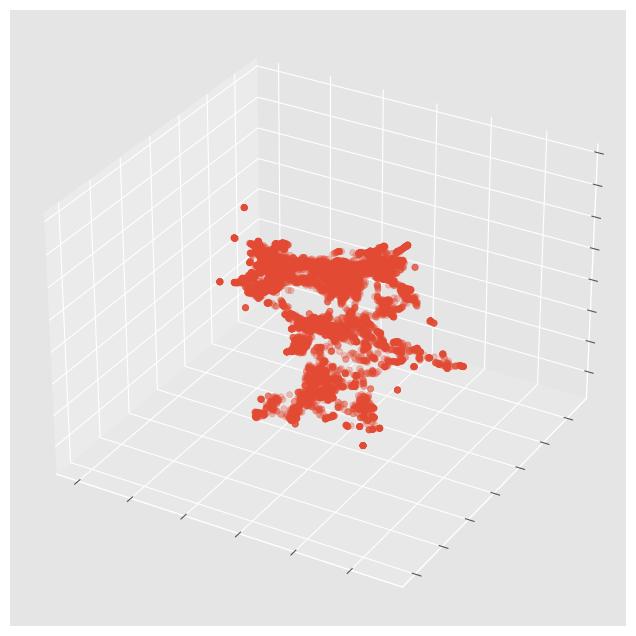

In [ ]:
# visualise embedding
svd = decomposition.TruncatedSVD(n_components=3)
pca_proj = svd.fit_transform(umap_embeddings)

x_plot = pca_proj[:, 0]
y_plot = pca_proj[:, 1]
z_plot = pca_proj[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.scatter(x_plot, y_plot, z_plot, alpha=0.3)

plt.show()

In [ ]:
# cluster
hdb = HDBSCAN(min_cluster_size=100,
              metric="euclidean",
              cluster_selection_method="eom")
hdb.fit(umap_embeddings)
cluster_labels = hdb.labels_

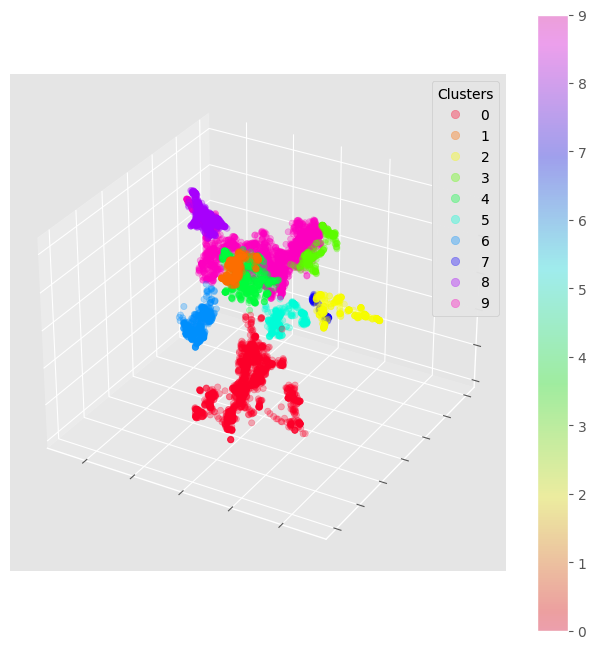

In [ ]:
plot_clusters(umap_embeddings, cluster_labels)

In [ ]:
# collate same clusters into 1 document
docs_df = pd.DataFrame({"Doc": course_rows})
docs_df['Topic'] = cluster_labels
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg(lambda x: " ".join([str(y) for y in x]))
docs_per_topic

,Topic,Doc
0,-1,python_data_structures great great content gre...
1,0,thank sir providing beautiful material nan gre...
2,1,easy one perfect beginner learning able unders...
3,2,amazing really good novice excellent like leve...
4,3,much text lot found non useful majority user c...
5,4,wonderful overall idea using lot help internet...
6,5,point view properly structured explained make ...
7,6,superb understood everything dr chuck taught w...
8,7,charles great teacher ability explain concept ...
9,8,excellent delivering good teaching enable stud...


In [ ]:
get_cluster_sizes(cluster_labels)

,cluster,size
0,-1,2995
1,0,1465
2,1,418
3,2,310
4,3,262
5,4,595
6,5,300
7,6,448
8,7,129
9,8,466


In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(course_rows))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
top_n_words

{-1: [('great', 0.04974471842908813),
  ('best', 0.04903108897552918),
  ('good', 0.040164369126577476),
  ('dr', 0.039226069913319575),
  ('chuck', 0.03651972609883603)],
 0: [('good', 0.08965771496435931),
  ('great', 0.07265985158780157),
  ('really', 0.06362660972776472),
  ('thank', 0.05678493376219221),
  ('helpful', 0.0551380784571837)],
 1: [('easy', 0.3341860344870194),
  ('understand', 0.1552809258101513),
  ('follow', 0.13636315906059754),
  ('simple', 0.079538774272348),
  ('learn', 0.05276057219782213)],
 2: [('beginner', 0.6673744812885076),
  ('good', 0.13950079026234483),
  ('best', 0.09945010908481439),
  ('great', 0.0808699926168778),
  ('excellent', 0.06429995941657882)],
 3: [('challenging', 0.11985338562655848),
  ('bit', 0.07807850718794125),
  ('difficult', 0.07311654577323394),
  ('little', 0.05693444859606126),
  ('assignment', 0.05641335302602564)],
 4: [('learning', 0.13431188765334925),
  ('learn', 0.11284990242681071),
  ('great', 0.06381124555718976),
  ('

In [ ]:
get_cluster_sentiment(cluster_labels)

,cluster,sentiment
0,-1,0.998664
1,0,0.999318
2,1,1.000000
3,2,1.000000
4,3,0.969466
5,4,1.000000
6,5,1.000000
7,6,1.000000
8,7,1.000000
9,8,1.000000


### <a>6.2.3 Conclusion</a>

Based on the results, the issues of imbalanced and noisy data persists. Hence, aspect-based sentiment analysis is still worth exploring.

## <a id="sentiment_prediction">6.3 Aspect-Based Sentiment Analysis</a>

In [ ]:
# get courses with most number of reviews
X.groupby("course_title")["review_processed_without_course_words"].count().reset_index().sort_values("review_processed_without_course_words", ascending=False).head(10)

,course_title,review_processed_without_course_words
131,COVID-19 Contact Tracing,9613
770,Python Data Structures,9538
176,Crash Course on Python,7582
451,Indigenous Canada,7242
832,Stanford Introduction to Food and Health,6894
922,Using Python to Access Web Data,6592
561,Introduction to Psychology,6387
446,Improving Deep Neural Networks: Hyperparameter...,6087
867,The Data Scientist’s Toolbox,5991
411,Google Cloud Fundamentals: Core Infrastructure,5907


Aspect-based sentiment analysis has been done on 2 courses: "Python Data Structures" and "The Data Scientist's Toolbox".

#### <a id="sentiment_prediction">6.3.1 Course: Python Data Structures</a>

Choose a course to do aspect-based sentiment analysis

In [ ]:
# choose a course to cluster
course_title = "Python Data Structures"

# get index of review rows that belong to this course
course_row_indices = X[X['course_title'] == course_title].index.values

In [ ]:
course_row_indices_negative = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 0)].index.values
course_row_indices_positive = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 1)].index.values

In [ ]:
df_ws_py_data_struct = df_ws[df_ws['course_title'] == course_title]
df_ws_py_data_struct.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words
248049,Python Data Structures,"python_data_structures=[""Great course!"", ""Grea...",5.0,1,"python_data_structures=[""great course!"", ""grea...",python_data_structures great course great cont...,python_data_structures great great content gre...
248050,Python Data Structures,Charles is a great teacher who has the ability...,5.0,1,charles is a great teacher who has the ability...,charles great teacher ability explain concept ...,charles great teacher ability explain concept ...
248051,Python Data Structures,This was a super-fun course! The materials wer...,5.0,1,this was a super-fun course! the materials wer...,super fun course material easy follow delivere...,super fun material easy follow delivered frien...
248052,Python Data Structures,I feel incredible that I knew almost nothing a...,5.0,1,i feel incredible that i knew almost nothing a...,feel incredible knew almost nothing programmin...,feel incredible knew almost nothing programmin...
248053,Python Data Structures,Dr. Chuck is awesome! I audited this and the ...,5.0,1,dr. chuck is awesome! i audited this and the ...,dr chuck awesome audited beginner class prepar...,dr chuck awesome audited beginner class prepar...


In [ ]:
df_ws_py_data_struct["rating_category"].value_counts()

1    9507
0      32
Name: rating_category, dtype: int64

Topic extraction using LDA

- Get main topics

In [ ]:
def tokenize_text(text):
  if isinstance(text, (str, bytes)):
    return word_tokenize(text)
  else:
    return []

In [ ]:
X_review_tokenized = X_review.iloc[course_row_indices].apply(tokenize_text)

In [ ]:
dictionary = Dictionary(X_review_tokenized)

corpus = [dictionary.doc2bow(doc) for doc in X_review_tokenized]

lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=10)

In [ ]:
print("\nLDA Model Topics:")
topics = lda_model.print_topics()
for topic in topics:
    print(topic)


LDA Model Topics:
(0, '0.087*"teaching" + 0.063*"charles" + 0.049*"love" + 0.043*"severance" + 0.043*"awesome" + 0.043*"way" + 0.037*"professor" + 0.032*"dr" + 0.023*"thank" + 0.022*"forward"')
(1, '0.060*"well" + 0.040*"explained" + 0.035*"good" + 0.032*"way" + 0.029*"taught" + 0.028*"concept" + 0.027*"loved" + 0.026*"lot" + 0.021*"great" + 0.020*"instructor"')
(2, '0.020*"programming" + 0.013*"not" + 0.013*"chuck" + 0.012*"dr" + 0.011*"learning" + 0.011*"code" + 0.009*"time" + 0.008*"first" + 0.008*"make" + 0.008*"like"')
(3, '0.115*"chuck" + 0.105*"dr" + 0.102*"great" + 0.039*"teacher" + 0.038*"lot" + 0.037*"thanks" + 0.035*"amazing" + 0.033*"learning" + 0.033*"excellent" + 0.032*"really"')
(4, '0.095*"easy" + 0.077*"beginner" + 0.045*"interesting" + 0.043*"great" + 0.043*"understand" + 0.042*"learn" + 0.038*"good" + 0.032*"useful" + 0.032*"recommend" + 0.025*"highly"')
(5, '0.175*"best" + 0.067*"one" + 0.041*"ever" + 0.033*"perfect" + 0.026*"programming" + 0.026*"learn" + 0.022*"b

- Consolidate topics that commonly appear and group related topics together

In [ ]:
aspect_groups = [["teaching", "explanation", "explained", "taught", "lecture"],    ["assignment", "exercise", "practice"],    ["teacher", "instructor", "professor", "dr"],    ["beginner", "basic"],    ["content", "material"]]

- Get the similarity of each review to these aspects

In [ ]:
fasttext_model = FastText(X_review_tokenized, vector_size= 50, window=5, min_count=5, workers=4,sg=1)

In [ ]:
def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

In [ ]:
df_ws_py_data_struct.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words
248049,Python Data Structures,"python_data_structures=[""Great course!"", ""Grea...",5.0,1,"python_data_structures=[""great course!"", ""grea...",python_data_structures great course great cont...,python_data_structures great great content gre...
248050,Python Data Structures,Charles is a great teacher who has the ability...,5.0,1,charles is a great teacher who has the ability...,charles great teacher ability explain concept ...,charles great teacher ability explain concept ...
248051,Python Data Structures,This was a super-fun course! The materials wer...,5.0,1,this was a super-fun course! the materials wer...,super fun course material easy follow delivere...,super fun material easy follow delivered frien...
248052,Python Data Structures,I feel incredible that I knew almost nothing a...,5.0,1,i feel incredible that i knew almost nothing a...,feel incredible knew almost nothing programmin...,feel incredible knew almost nothing programmin...
248053,Python Data Structures,Dr. Chuck is awesome! I audited this and the ...,5.0,1,dr. chuck is awesome! i audited this and the ...,dr chuck awesome audited beginner class prepar...,dr chuck awesome audited beginner class prepar...


In [ ]:
from tqdm import tqdm
tqdm.pandas()
for aspect_group in aspect_groups:
  for aspect in aspect_group:
    df_ws_py_data_struct[aspect] = df_ws_py_data_struct['review_processed_without_course_words'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9539/9539 [00:15<00:00, 605.48it/s] 
<ipython-input-228-fc3c8346a3be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_py_data_struct[aspect] = df_ws_py_data_struct['review_processed_without_course_words'].progress_map(lambda text: get_similarity(text, aspect))
100%|██████████| 9539/9539 [00:14<00:00, 640.28it/s] 
<ipython-input-228-fc3c8346a3be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_py_data_struct[aspect] = df_ws_py_data_struct['review_processed_without_course_words'

In [ ]:
# to save pre-processed df into csv
# df_ws_py_data_struct.to_csv("course-reviews-webscraped-processed-eng-lang-py-data-struct-with-similarities.csv", sep=",")

In [ ]:
# to load pre-processed df
# Download the dataset
download_from_gdrive("1byPBiu6RWL31thRPbUI76T0f8_Fy623e", "course-reviews-webscraped-processed-eng-lang-py-data-struct-with-similarities.csv")

Downloading...
From: https://drive.google.com/uc?id=1byPBiu6RWL31thRPbUI76T0f8_Fy623e
To: /content/course-reviews-webscraped-processed-eng-lang-py-data-struct-with-similarities.csv
100%|██████████| 6.79M/6.79M [00:00<00:00, 37.5MB/s]


In [ ]:
df_ws_py_data_struct = pd.read_csv("course-reviews-webscraped-processed-eng-lang-py-data-struct-with-similarities.csv", sep=',', index_col=False)
df_ws_py_data_struct = df_ws_py_data_struct.drop(["Unnamed: 0"], axis=1)
df_ws_py_data_struct.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words,teaching,explanation,explained,...,exercise,practice,teacher,instructor,professor,dr,beginner,basic,content,material
0,Python Data Structures,"python_data_structures=[""Great course!"", ""Grea...",5.0,1,"python_data_structures=[""great course!"", ""grea...",python_data_structures great course great cont...,python_data_structures great great content gre...,0.936082,0.963546,0.950710,...,0.950651,0.949767,0.950802,0.956403,0.961256,0.955146,0.945121,0.791801,0.953496,0.958305
1,Python Data Structures,Charles is a great teacher who has the ability...,5.0,1,charles is a great teacher who has the ability...,charles great teacher ability explain concept ...,charles great teacher ability explain concept ...,0.962621,0.971144,0.965707,...,0.965405,0.945439,0.963027,0.910965,0.939728,0.932117,0.962855,0.796405,0.970264,0.959671
2,Python Data Structures,This was a super-fun course! The materials wer...,5.0,1,this was a super-fun course! the materials wer...,super fun course material easy follow delivere...,super fun material easy follow delivered frien...,0.959244,0.978836,0.977576,...,0.972383,0.933950,0.965544,0.910758,0.949487,0.947995,0.976042,0.757940,0.969176,0.970842
3,Python Data Structures,I feel incredible that I knew almost nothing a...,5.0,1,i feel incredible that i knew almost nothing a...,feel incredible knew almost nothing programmin...,feel incredible knew almost nothing programmin...,0.959580,0.969796,0.963627,...,0.961610,0.941306,0.958376,0.911261,0.938091,0.932677,0.960703,0.790835,0.967520,0.957516
4,Python Data Structures,Dr. Chuck is awesome! I audited this and the ...,5.0,1,dr. chuck is awesome! i audited this and the ...,dr chuck awesome audited beginner class prepar...,dr chuck awesome audited beginner class prepar...,0.956702,0.974571,0.972560,...,0.970666,0.938366,0.966493,0.914832,0.948241,0.942795,0.969588,0.770080,0.968197,0.967673


- Combine similar aspects to form aspect groups

In [ ]:
# combine similar aspects to form aspect groups
for aspect_group in aspect_groups:
  aspect_group_name = "_".join(aspect_group)

  #choose the highest similarity value within the aspect group
  df_ws_py_data_struct[f'similarity__{aspect_group_name}'] = df_ws_py_data_struct[aspect_group].max(axis=1)

df_ws_py_data_struct.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words,teaching,explanation,explained,...,dr,beginner,basic,content,material,similarity__teaching_explanation_explained_taught_lecture,similarity__assignment_exercise_practice,similarity__teacher_instructor_professor_dr,similarity__beginner_basic,similarity__content_material
0,Python Data Structures,"python_data_structures=[""Great course!"", ""Grea...",5.0,1,"python_data_structures=[""great course!"", ""grea...",python_data_structures great course great cont...,python_data_structures great great content gre...,0.936082,0.963546,0.950710,...,0.955146,0.945121,0.791801,0.953496,0.958305,0.964849,0.950651,0.961256,0.945121,0.958305
1,Python Data Structures,Charles is a great teacher who has the ability...,5.0,1,charles is a great teacher who has the ability...,charles great teacher ability explain concept ...,charles great teacher ability explain concept ...,0.962621,0.971144,0.965707,...,0.932117,0.962855,0.796405,0.970264,0.959671,0.971144,0.967744,0.963027,0.962855,0.970264
2,Python Data Structures,This was a super-fun course! The materials wer...,5.0,1,this was a super-fun course! the materials wer...,super fun course material easy follow delivere...,super fun material easy follow delivered frien...,0.959244,0.978836,0.977576,...,0.947995,0.976042,0.757940,0.969176,0.970842,0.978836,0.976092,0.965544,0.976042,0.970842
3,Python Data Structures,I feel incredible that I knew almost nothing a...,5.0,1,i feel incredible that i knew almost nothing a...,feel incredible knew almost nothing programmin...,feel incredible knew almost nothing programmin...,0.959580,0.969796,0.963627,...,0.932677,0.960703,0.790835,0.967520,0.957516,0.969796,0.966874,0.958376,0.960703,0.967520
4,Python Data Structures,Dr. Chuck is awesome! I audited this and the ...,5.0,1,dr. chuck is awesome! i audited this and the ...,dr chuck awesome audited beginner class prepar...,dr chuck awesome audited beginner class prepar...,0.956702,0.974571,0.972560,...,0.942795,0.969588,0.770080,0.968197,0.967673,0.974571,0.970666,0.966493,0.969588,0.968197


- Try doing sentiment prediction using a few sample reviews

In [ ]:
download_from_gdrive("1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t", "PRED-svc_clf__ngrams_us.joblib")
svc_clf__ngrams_us = joblib.load('PRED-svc_clf__ngrams_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t
To: /content/PRED-svc_clf__ngrams_us.joblib
100%|██████████| 23.4M/23.4M [00:00<00:00, 50.7MB/s]


In [ ]:
download_from_gdrive("1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC", "PRED-ngrams_transform.joblib")
ngrams = joblib.load('PRED-ngrams_transform.joblib')

Downloading...
From: https://drive.google.com/uc?id=1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC
To: /content/PRED-ngrams_transform.joblib
100%|██████████| 30.5M/30.5M [00:00<00:00, 52.7MB/s]


In [ ]:
x_sample = np.array(["I really enjoyed this content. The instructor was very good.", "This class is bad and the assignments are difficult."])
y_sample = np.array([1, 0])

x_sample_ngrams = ngrams.transform(x_sample)
pred_probas = svc_clf__ngrams_us.predict_proba(x_sample_ngrams)[:, 1]

for i in range(len(pred_probas)):
  print(f"For review: {x_sample[i]}")
  print(f'Predict Probability: {pred_probas[i]}')

  print(f'Predict Binary: {1 if pred_probas[i] > 0.5 else 0}')
  print(f"Predicted Sentiment: {'Positive' if pred_probas[i] > 0.5 else 'Negative'}")
  print(f'Actual Sentiment: {"Positive" if y_sample[i] == 1 else "Negative"}')

For review: I really enjoyed this content. The instructor was very good.
Predict Probability: 0.9907165422498632
Predict Binary: 1
Predicted Sentiment: Positive
Actual Sentiment: Positive
For review: This class is bad and the assignments are difficult.
Predict Probability: 0.014912951153957523
Predict Binary: 0
Predicted Sentiment: Negative
Actual Sentiment: Negative


- Try doing aspect-based sentiment prediction using a few sample reviews

In [ ]:
text_reviews = pd.Series(["i really enjoyed this content and exercises. the instructor was very good! however, the assignments are difficult? This class is amazing.", "this is great"])
sample_df = pd.DataFrame(text_reviews, columns = ['review'])


def get_pred_probs(review_col):
  all_row_dicts = []

  # for each review
  for ind in review_col.index.values:
    text_review = review_col[ind]
    # split entire review into multiple sentences
    text_review_sentences = [sentence.strip() for sentence in re.split('\.|\!|\?', text_review)]
    text_review_sentences = list(filter(None, text_review_sentences))
    aspect_prob_dict_per_review = {}

    # for each sentence
    for j in range(len(text_review_sentences)):
      text_review_sentence = text_review_sentences[j]
      sentence_relevant_aspects = set()

      # lemmatize this sentence
      text_review_sentence_lemmatized = lemmatize(text_review_sentence)

      # get aspect groups relevant to this sentence
      for token in tokenize_text(lemmatize(text_review_sentence)):
        for aspect_group in aspect_groups:
          if token in aspect_group:
            sentence_relevant_aspects.add("_".join(aspect_group))

      # get sentiment prediction probability of this sentence
      text_review_sentence_ngrams = ngrams.transform(np.array([text_review_sentence]))
      pred_proba = svc_clf__ngrams_us.predict_proba(text_review_sentence_ngrams)[:, 1][0]

      # for aspects that are relevant to this sentence, collate the pred probs for each aspect for this entire review
      for sentence_relevant_aspect in sentence_relevant_aspects:
        if sentence_relevant_aspect not in aspect_prob_dict_per_review.keys():
          aspect_prob_dict_per_review[sentence_relevant_aspect] = (pred_proba, 1)
        else:
          curr_tup = aspect_prob_dict_per_review[sentence_relevant_aspect]
          aspect_prob_dict_per_review[sentence_relevant_aspect] = (curr_tup[0] + pred_proba, curr_tup[1] + 1 )


    # for each review, get pred prob per aspect group (find average if review has multiple sentences that are related to the same aspect group)
    row_dict = {}
    for aspect_group in aspect_groups:
      aspect_group_name = "_".join(aspect_group)
      if aspect_group_name in aspect_prob_dict_per_review.keys():
        avg_prob_per_aspect = aspect_prob_dict_per_review[aspect_group_name][0] / aspect_prob_dict_per_review[aspect_group_name][1]
        row_dict[f'predprob__{aspect_group_name}'] = avg_prob_per_aspect
      else:
        row_dict[f'predprob__{aspect_group_name}'] = np.NaN

    all_row_dicts.append(row_dict)

  return pd.DataFrame(all_row_dicts)


In [ ]:
get_pred_probs(text_reviews)

,predprob__teaching_explanation_explained_taught_lecture,predprob__assignment_exercise_practice,predprob__teacher_instructor_professor_dr,predprob__beginner_basic,predprob__content_material
0,NaN,0.483762,0.895356,NaN,0.948523
1,NaN,NaN,NaN,NaN,NaN


- Doing aspect-based sentiment prediction for the chosen course


In [ ]:
pred_probs = get_pred_probs(df_ws_py_data_struct["review_not_processed"])
pred_probs

,predprob__teaching_explanation_explained_taught_lecture,predprob__assignment_exercise_practice,predprob__teacher_instructor_professor_dr,predprob__beginner_basic,predprob__content_material
0,NaN,NaN,0.930188,NaN,0.919844
1,NaN,NaN,0.976319,0.971955,NaN
2,NaN,NaN,NaN,NaN,0.967487
3,NaN,NaN,NaN,0.091684,NaN
4,0.999998,0.999998,0.872535,0.551393,NaN
...,...,...,...,...,...
9534,NaN,NaN,NaN,NaN,NaN
9535,NaN,NaN,NaN,0.919853,NaN
9536,NaN,NaN,NaN,NaN,NaN
9537,NaN,NaN,NaN,NaN,NaN


In [ ]:
pred_probs.count()

predprob__teaching_explanation_explained_taught_lecture    1640
predprob__assignment_exercise_practice                      982
predprob__teacher_instructor_professor_dr                  3186
predprob__beginner_basic                                   1167
predprob__content_material                                  616
dtype: int64

In [ ]:
# add predprob columns to dataframe
similarity_cols = [col for col in df_ws_py_data_struct if col.startswith('similarity__')]

sim_predprob_df_ws_py_data_struct = pd.concat([df_ws_py_data_struct[["review"] + similarity_cols], pred_probs], axis=1)
sim_predprob_df_ws_py_data_struct

,review,similarity__teaching_explanation_explained_taught_lecture,similarity__assignment_exercise_practice,similarity__teacher_instructor_professor_dr,similarity__beginner_basic,similarity__content_material,predprob__teaching_explanation_explained_taught_lecture,predprob__assignment_exercise_practice,predprob__teacher_instructor_professor_dr,predprob__beginner_basic,predprob__content_material
0,"python_data_structures=[""Great course!"", ""Grea...",0.964849,0.950651,0.961256,0.945121,0.958305,NaN,NaN,0.930188,NaN,0.919844
1,Charles is a great teacher who has the ability...,0.971144,0.967744,0.963027,0.962855,0.970264,NaN,NaN,0.976319,0.971955,NaN
2,This was a super-fun course! The materials wer...,0.978836,0.976092,0.965544,0.976042,0.970842,NaN,NaN,NaN,NaN,0.967487
3,I feel incredible that I knew almost nothing a...,0.969796,0.966874,0.958376,0.960703,0.967520,NaN,NaN,NaN,0.091684,NaN
4,Dr. Chuck is awesome! I audited this and the ...,0.974571,0.970666,0.966493,0.969588,0.968197,0.999998,0.999998,0.872535,0.551393,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9534,It is very usefull course,0.926473,0.846448,0.919751,0.832983,0.873136,NaN,NaN,NaN,NaN,NaN
9535,Good course for beginners,0.983176,0.989329,0.966732,0.987161,0.974087,NaN,NaN,NaN,0.919853,NaN
9536,Very practical and useful,0.957446,0.949904,0.972648,0.887848,0.919802,NaN,NaN,NaN,NaN,NaN
9537,"Very good, recommendable!\n",0.985789,0.985259,0.976855,0.983872,0.982777,NaN,NaN,NaN,NaN,NaN


- Find consolidated sentiment prediction probability per aspect group

In [ ]:
for aspect_group in aspect_groups:
  aspect_group_name = "_".join(aspect_group)

  # only include reviews that talk about that aspect
  no_nan = sim_predprob_df_ws_py_data_struct[[f"similarity__{aspect_group_name}", f"predprob__{aspect_group_name}"]].dropna()

  # get weighted average of pred probability based on similarity of review to aspect (reviews that are more similar to the particular aspect get a higher weightage)
  weighted_avg_pred_prob_per_aspect = np.sum(no_nan[f"similarity__{aspect_group_name}"] * no_nan[f"predprob__{aspect_group_name}"]) / np.sum(no_nan[f"similarity__{aspect_group_name}"])

  print(f"Predicted sentiment probability for {aspect_group_name}: {weighted_avg_pred_prob_per_aspect} ({'Positive' if weighted_avg_pred_prob_per_aspect > 0.5 else 'Negative'})")


Predicted sentiment probability for teaching_explanation_explained_taught_lecture: 0.8421815650647932 (Positive)
Predicted sentiment probability for assignment_exercise_practice: 0.6891501823754596 (Positive)
Predicted sentiment probability for teacher_instructor_professor_dr: 0.8976228877157366 (Positive)
Predicted sentiment probability for beginner_basic: 0.8144700853169299 (Positive)
Predicted sentiment probability for content_material: 0.7709037658797996 (Positive)


Results suggest that the sentiment for all aspects are generally positive for this course, with the course instructor of the course having the highest predicted sentiment probability. However, the predicted sentiment probability for work and assessments provided to the students, such as assignments, exercises or practices, have the lowest value so that can be something that the course instructor can look into and improve on.

In [ ]:
reviews_related_to_assignment_exercise_practice = df_ws_py_data_struct[df_ws_py_data_struct['review'].str.contains("assignment|exercise|practice", case=False, na=False)]["review"]
reviews_related_to_assignment_exercise_practice.tolist()[:10]

["Dr. Chuck is awesome!  I audited this and the beginner class to prepare for a training course for work . I needed to prepare to learn an AV system control scripting software that uses a Python-based language. I tried some Code Academy lessons and some other short interactive tutorials but I just wasn't getting the deeper, meaningful learning experience that I was looking for. This truly feels like having access to a university course on the subject (if you continue with the other courses in this specialization after this). The lectures are great, I highly recommend also reading the textbook as well to get a deeper understanding, and doing the auto-grader assignments to verify your working knowledge is a great tool. The time and effort commitment for the first 2 courses has felt like a light load, a great way to get started if you're feeling overwhelmed about learning a scripting language. Thank you Dr. Chuck!!!!",
 'assignment 9.4 auto grader not working .LTI unable to launch.error m

As seen in some of these reviews, while many students have positive experiences with the assignments or exercises *(e.g. "doing the auto-grader assignments to verify your working knowledge is a great tool", "confident in my ability to complete the assignments")*, there are also some reviews mentioning the issues with these assignments that the course instructor can improve on (e.g. "assignment 9.4 auto grader not working", "Assignments are harder than the examples in the lecture").

#### <a id="sentiment_prediction">6.3.2 Course: The Data Scientist’s Toolbox</a>



Choose a course to do aspect-based sentiment analysis

In [ ]:
# choose a course to analyse
course_title = "The Data Scientist’s Toolbox"

# get index of review rows that belong to this course
course_row_indices = X[X['course_title'] == course_title].index.values

In [ ]:
course_row_indices_negative = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 0)].index.values
course_row_indices_positive = y[(X['course_title'] == course_title) & (y_with_course_title["rating_category"] == 1)].index.values

In [ ]:
df_ws_ds_toolbox = df_ws[df_ws['course_title'] == course_title]
df_ws_ds_toolbox.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words
457804,The Data Scientist’s Toolbox,!!!STOP DON'T TAKE THIS COURSE!!!%100 pure adv...,1.0,0,!!!stop don't take this course!!!%100 pure adv...,stop take course pure advertising moment felt ...,stop take pure advertising moment felt like le...
457805,The Data Scientist’s Toolbox,This course was a good intro especially in set...,5.0,1,this course was a good intro especially in set...,course good intro especially setting necessary...,good intro especially setting necessary softwa...
457806,The Data Scientist’s Toolbox,This should not be a course. It's just introdu...,1.0,0,this should not be a course. it's just introdu...,not course introduction condensed one video ha...,not introduction condensed one video handout p...
457807,The Data Scientist’s Toolbox,Not met what offered. I really don't know why ...,1.0,0,not met what offered. i really don't know why ...,not met offered really know instructor hurry l...,not met offered really know instructor hurry l...
457808,The Data Scientist’s Toolbox,"Basic introduction for the specialization, pri...",2.0,0,"basic introduction for the specialization, pri...",basic introduction specialization principle da...,basic introduction specialization principle sc...


In [ ]:
df_ws_ds_toolbox["rating_category"].value_counts()

1    5245
0     746
Name: rating_category, dtype: int64

Topic extraction using LDA

- Get main topics

In [ ]:
X_review_tokenized = X_review.iloc[course_row_indices].apply(tokenize_text)

In [ ]:
dictionary = Dictionary(X_review_tokenized)

corpus = [dictionary.doc2bow(doc) for doc in X_review_tokenized]

lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=10)

In [ ]:
print("\nLDA Model Topics:")
topics = lda_model.print_topics()
for topic in topics:
    print(topic)


LDA Model Topics:
(0, '0.057*"github" + 0.051*"git" + 0.036*"r" + 0.033*"rstudio" + 0.020*"use" + 0.018*"step" + 0.014*"version" + 0.011*"lot" + 0.011*"command" + 0.011*"clear"')
(1, '0.037*"not" + 0.024*"would" + 0.014*"like" + 0.012*"really" + 0.011*"video" + 0.010*"little" + 0.010*"think" + 0.010*"question" + 0.010*"quiz" + 0.009*"feel"')
(2, '0.023*"not" + 0.017*"r" + 0.015*"week" + 0.014*"one" + 0.013*"could" + 0.010*"basic" + 0.009*"would" + 0.009*"content" + 0.009*"like" + 0.008*"time"')
(3, '0.030*"simple" + 0.026*"video" + 0.025*"looking" + 0.025*"forward" + 0.020*"voice" + 0.019*"automated" + 0.015*"teaching" + 0.014*"like" + 0.014*"learning" + 0.014*"way"')
(4, '0.123*"easy" + 0.100*"well" + 0.048*"follow" + 0.038*"understand" + 0.031*"informative" + 0.028*"structured" + 0.028*"explained" + 0.017*"good" + 0.016*"clear" + 0.015*"material"')
(5, '0.056*"beginner" + 0.044*"thank" + 0.044*"useful" + 0.043*"really" + 0.036*"lot" + 0.034*"good" + 0.027*"thanks" + 0.027*"interesti

- Consolidate topics that commonly appear and group related topics together

In [ ]:
aspect_groups = [["github", "git"],   ["r", "rstudio"],    ["quiz"],    ["basic", "beginner", "introduction", "intro", "start", "introductory", "starting"],    ["content", "material"],    ["explained", "follow", "understand"],    ["instructor"]]

- Get the similarity of each review to these aspects

In [ ]:
fasttext_model = FastText(X_review_tokenized, vector_size= 50, window=5, min_count=5, workers=4,sg=1)

In [ ]:
df_ws_ds_toolbox.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words
457804,The Data Scientist’s Toolbox,!!!STOP DON'T TAKE THIS COURSE!!!%100 pure adv...,1.0,0,!!!stop don't take this course!!!%100 pure adv...,stop take course pure advertising moment felt ...,stop take pure advertising moment felt like le...
457805,The Data Scientist’s Toolbox,This course was a good intro especially in set...,5.0,1,this course was a good intro especially in set...,course good intro especially setting necessary...,good intro especially setting necessary softwa...
457806,The Data Scientist’s Toolbox,This should not be a course. It's just introdu...,1.0,0,this should not be a course. it's just introdu...,not course introduction condensed one video ha...,not introduction condensed one video handout p...
457807,The Data Scientist’s Toolbox,Not met what offered. I really don't know why ...,1.0,0,not met what offered. i really don't know why ...,not met offered really know instructor hurry l...,not met offered really know instructor hurry l...
457808,The Data Scientist’s Toolbox,"Basic introduction for the specialization, pri...",2.0,0,"basic introduction for the specialization, pri...",basic introduction specialization principle da...,basic introduction specialization principle sc...


In [ ]:
from tqdm import tqdm
tqdm.pandas()
for aspect_group in aspect_groups:
  for aspect in aspect_group:
    df_ws_ds_toolbox[aspect] = df_ws_ds_toolbox['review_processed_without_course_words'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 5991/5991 [00:07<00:00, 851.06it/s]
<ipython-input-123-0c1a2f2be83a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_ds_toolbox[aspect] = df_ws_ds_toolbox['review_processed_without_course_words'].progress_map(lambda text: get_similarity(text, aspect))
100%|██████████| 5991/5991 [00:09<00:00, 605.60it/s]
<ipython-input-123-0c1a2f2be83a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_ds_toolbox[aspect] = df_ws_ds_toolbox['review_processed_without_course_words'].progress_map(lam

In [ ]:
# to save pre-processed df into csv
# df_ws_ds_toolbox.to_csv("course-reviews-webscraped-processed-eng-lang-ds-toolbox-with-similarities.csv", sep=",")

In [ ]:
# to load pre-processed df
# Download the dataset
download_from_gdrive("1uBIZyuXt84zKGNIIeN-K8HD38AAQsy0D", "course-reviews-webscraped-processed-eng-lang-ds-toolbox-with-similarities.csv")

Downloading...
From: https://drive.google.com/uc?id=1uBIZyuXt84zKGNIIeN-K8HD38AAQsy0D
To: /content/course-reviews-webscraped-processed-eng-lang-ds-toolbox-with-similarities.csv
100%|██████████| 3.48M/3.48M [00:00<00:00, 21.6MB/s]


In [ ]:
df_ws_ds_toolbox = pd.read_csv("course-reviews-webscraped-processed-eng-lang-ds-toolbox-with-similarities.csv", sep=',', index_col=False)
df_ws_ds_toolbox = df_ws_ds_toolbox.drop(["Unnamed: 0"], axis=1)
df_ws_ds_toolbox.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words,github,git,r,...,intro,start,introductory,starting,content,material,explained,follow,understand,instructor
0,The Data Scientist’s Toolbox,!!!STOP DON'T TAKE THIS COURSE!!!%100 pure adv...,1.0,0,!!!stop don't take this course!!!%100 pure adv...,stop take course pure advertising moment felt ...,stop take pure advertising moment felt like le...,0.934335,0.924951,0.807889,...,0.810922,0.795154,0.928826,0.907710,0.936970,0.898360,0.936889,0.888297,0.945199,0.915301
1,The Data Scientist’s Toolbox,This course was a good intro especially in set...,5.0,1,this course was a good intro especially in set...,course good intro especially setting necessary...,good intro especially setting necessary softwa...,0.952741,0.939773,0.841028,...,0.841053,0.826276,0.955470,0.934259,0.949590,0.926524,0.952918,0.903626,0.968905,0.942761
2,The Data Scientist’s Toolbox,This should not be a course. It's just introdu...,1.0,0,this should not be a course. it's just introdu...,not course introduction condensed one video ha...,not introduction condensed one video handout p...,0.941611,0.934131,0.792088,...,0.796545,0.779167,0.925192,0.900755,0.946708,0.890905,0.945362,0.894592,0.946638,0.908999
3,The Data Scientist’s Toolbox,Not met what offered. I really don't know why ...,1.0,0,not met what offered. i really don't know why ...,not met offered really know instructor hurry l...,not met offered really know instructor hurry l...,0.919566,0.912857,0.789401,...,0.795422,0.777960,0.911919,0.891556,0.926381,0.881143,0.923060,0.879246,0.928450,0.898308
4,The Data Scientist’s Toolbox,"Basic introduction for the specialization, pri...",2.0,0,"basic introduction for the specialization, pri...",basic introduction specialization principle da...,basic introduction specialization principle sc...,0.933077,0.924579,0.809828,...,0.813220,0.798175,0.929302,0.909342,0.936460,0.900425,0.935752,0.888032,0.944861,0.916264


- Combine similar aspects to form aspect groups

In [ ]:
# combine similar aspects to form aspect groups
for aspect_group in aspect_groups:
  aspect_group_name = "_".join(aspect_group)

  #choose the highest similarity value within the aspect group
  df_ws_ds_toolbox[f'similarity__{aspect_group_name}'] = df_ws_ds_toolbox[aspect_group].max(axis=1)

df_ws_ds_toolbox.head()

,course_title,review,star_ratings,rating_category,review_not_processed,review_processed,review_processed_without_course_words,github,git,r,...,follow,understand,instructor,similarity__github_git,similarity__r_rstudio,similarity__quiz,similarity__basic_beginner_introduction_intro_start_introductory_starting,similarity__content_material,similarity__explained_follow_understand,similarity__instructor
0,The Data Scientist’s Toolbox,!!!STOP DON'T TAKE THIS COURSE!!!%100 pure adv...,1.0,0,!!!stop don't take this course!!!%100 pure adv...,stop take course pure advertising moment felt ...,stop take pure advertising moment felt like le...,0.934335,0.924951,0.807889,...,0.888297,0.945199,0.915301,0.934335,0.931676,0.899842,0.946525,0.936970,0.945199,0.915301
1,The Data Scientist’s Toolbox,This course was a good intro especially in set...,5.0,1,this course was a good intro especially in set...,course good intro especially setting necessary...,good intro especially setting necessary softwa...,0.952741,0.939773,0.841028,...,0.903626,0.968905,0.942761,0.952741,0.958253,0.922788,0.969760,0.949590,0.968905,0.942761
2,The Data Scientist’s Toolbox,This should not be a course. It's just introdu...,1.0,0,this should not be a course. it's just introdu...,not course introduction condensed one video ha...,not introduction condensed one video handout p...,0.941611,0.934131,0.792088,...,0.894592,0.946638,0.908999,0.941611,0.929136,0.908014,0.946528,0.946708,0.946638,0.908999
3,The Data Scientist’s Toolbox,Not met what offered. I really don't know why ...,1.0,0,not met what offered. i really don't know why ...,not met offered really know instructor hurry l...,not met offered really know instructor hurry l...,0.919566,0.912857,0.789401,...,0.879246,0.928450,0.898308,0.919566,0.914143,0.882400,0.930427,0.926381,0.928450,0.898308
4,The Data Scientist’s Toolbox,"Basic introduction for the specialization, pri...",2.0,0,"basic introduction for the specialization, pri...",basic introduction specialization principle da...,basic introduction specialization principle sc...,0.933077,0.924579,0.809828,...,0.888032,0.944861,0.916264,0.933077,0.931753,0.898052,0.946330,0.936460,0.944861,0.916264


- Try doing aspect-based sentiment prediction using a few sample reviews

In [ ]:
download_from_gdrive("1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t", "PRED-svc_clf__ngrams_us.joblib")
svc_clf__ngrams_us = joblib.load('PRED-svc_clf__ngrams_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t
To: /content/PRED-svc_clf__ngrams_us.joblib
100%|██████████| 23.4M/23.4M [00:00<00:00, 50.7MB/s]


In [ ]:
download_from_gdrive("1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC", "PRED-ngrams_transform.joblib")
ngrams = joblib.load('PRED-ngrams_transform.joblib')

Downloading...
From: https://drive.google.com/uc?id=1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC
To: /content/PRED-ngrams_transform.joblib
100%|██████████| 30.5M/30.5M [00:00<00:00, 52.7MB/s]


In [ ]:
text_reviews = pd.Series(["i really enjoyed this content and exercises. the instructor was very good! however, the assignments are difficult? This class is amazing.", "this is great"])
sample_df = pd.DataFrame(text_reviews, columns = ['review'])

In [ ]:
get_pred_probs(text_reviews)

,predprob__github_git,predprob__r_rstudio,predprob__quiz,predprob__basic_beginner_introduction_intro_start_introductory_starting,predprob__content_material,predprob__explained_follow_understand,predprob__instructor
0,NaN,NaN,NaN,NaN,0.948523,NaN,0.895356
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Doing aspect-based sentiment prediction for the chosen course

In [ ]:
pred_probs = get_pred_probs(df_ws_ds_toolbox["review_not_processed"])
pred_probs

,predprob__github_git,predprob__r_rstudio,predprob__quiz,predprob__basic_beginner_introduction_intro_start_introductory_starting,predprob__content_material,predprob__explained_follow_understand,predprob__instructor
0,0.187522,0.200883,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.951926,NaN,NaN,NaN
2,0.500000,0.500000,NaN,0.069822,NaN,NaN,NaN
3,NaN,NaN,NaN,0.030517,NaN,0.057261,0.655973
4,NaN,0.165150,NaN,0.022827,0.00816,NaN,NaN
...,...,...,...,...,...,...,...
5986,NaN,NaN,NaN,0.013428,NaN,NaN,NaN
5987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5989,NaN,NaN,NaN,0.140991,NaN,NaN,NaN


In [ ]:
pred_probs.count()

predprob__github_git                                                        634
predprob__r_rstudio                                                         725
predprob__quiz                                                              106
predprob__basic_beginner_introduction_intro_start_introductory_starting    2337
predprob__content_material                                                  553
predprob__explained_follow_understand                                       503
predprob__instructor                                                         93
dtype: int64

In [ ]:
# add predprob columns to dataframe
similarity_cols = [col for col in df_ws_ds_toolbox if col.startswith('similarity__')]

sim_predprob_df_ws_ds_toolbox = pd.concat([df_ws_ds_toolbox[["review"] + similarity_cols], pred_probs], axis=1)
sim_predprob_df_ws_ds_toolbox

,review,similarity__github_git,similarity__r_rstudio,similarity__quiz,similarity__basic_beginner_introduction_intro_start_introductory_starting,similarity__content_material,similarity__explained_follow_understand,similarity__instructor,predprob__github_git,predprob__r_rstudio,predprob__quiz,predprob__basic_beginner_introduction_intro_start_introductory_starting,predprob__content_material,predprob__explained_follow_understand,predprob__instructor
0,!!!STOP DON'T TAKE THIS COURSE!!!%100 pure adv...,0.934335,0.931676,0.899842,0.946525,0.936970,0.945199,0.915301,0.187522,0.200883,NaN,NaN,NaN,NaN,NaN
1,This course was a good intro especially in set...,0.952741,0.958253,0.922788,0.969760,0.949590,0.968905,0.942761,NaN,NaN,NaN,0.951926,NaN,NaN,NaN
2,This should not be a course. It's just introdu...,0.941611,0.929136,0.908014,0.946528,0.946708,0.946638,0.908999,0.500000,0.500000,NaN,0.069822,NaN,NaN,NaN
3,Not met what offered. I really don't know why ...,0.919566,0.914143,0.882400,0.930427,0.926381,0.928450,0.898308,NaN,NaN,NaN,0.030517,NaN,0.057261,0.655973
4,"Basic introduction for the specialization, pri...",0.933077,0.931753,0.898052,0.946330,0.936460,0.944861,0.916264,NaN,0.165150,NaN,0.022827,0.00816,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986,Very basic and boring,0.920608,0.944901,0.885256,0.951237,0.927409,0.946197,0.939405,NaN,NaN,NaN,0.013428,NaN,NaN,NaN
5987,not much interactive,0.946885,0.935674,0.912596,0.953319,0.952688,0.952378,0.917155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5988,Ass robotic stuff,0.885272,0.912707,0.847296,0.916788,0.894328,0.911740,0.908329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5989,very basic.,0.920750,0.840700,0.875110,0.948837,0.921276,0.922525,0.805006,NaN,NaN,NaN,0.140991,NaN,NaN,NaN


- Find consolidated sentiment prediction probability per aspect group

In [ ]:
for aspect_group in aspect_groups:
  aspect_group_name = "_".join(aspect_group)

  # only include reviews that talk about that aspect
  no_nan = sim_predprob_df_ws_ds_toolbox[[f"similarity__{aspect_group_name}", f"predprob__{aspect_group_name}"]].dropna()

  # get weighted average of pred probability based on similarity of review to aspect
  weighted_avg_pred_prob_per_aspect = np.sum(no_nan[f"similarity__{aspect_group_name}"] * no_nan[f"predprob__{aspect_group_name}"]) / np.sum(no_nan[f"similarity__{aspect_group_name}"])

  print(f"Predicted sentiment probability for {aspect_group_name}: {weighted_avg_pred_prob_per_aspect} ({'Positive' if weighted_avg_pred_prob_per_aspect > 0.5 else 'Negative'})")


Predicted sentiment probability for github_git: 0.6024148254045768 (Positive)
Predicted sentiment probability for r_rstudio: 0.6624030282492996 (Positive)
Predicted sentiment probability for quiz: 0.39821169341826407 (Negative)
Predicted sentiment probability for basic_beginner_introduction_intro_start_introductory_starting: 0.7464543997801948 (Positive)
Predicted sentiment probability for content_material: 0.5404403766032689 (Positive)
Predicted sentiment probability for explained_follow_understand: 0.6803104698058347 (Positive)
Predicted sentiment probability for instructor: 0.5433046602844305 (Positive)


Results suggest that the sentiment for all aspects are generally positive for this course, with the quizzes of the course having negative sentiment. The predicted sentiment probability for the aspect regarding this course being a beginner/introductory course is the highest, which may suggest that this course is doing well or suitable for beginner students. However, in comparison with the predicted sentiment probability of the Python Data Structures course, the predicted sentiment probability of this course is generally lower, despite having positive sentiment for most aspects when probability threshold for postitive sentiment is set at 0.5. This suggests that the course can still be improved based on the aspects listed here, especially for the quiz or assessment component as it has negative sentiment.

In [ ]:
reviews_related_to_quiz = df_ws_ds_toolbox[df_ws_ds_toolbox['review'].str.contains("quiz", case=False, na=False)]["review"]
reviews_related_to_quiz.tolist()[:10]

['As a business student from Bangladesh who is aspiring to be a data analyst in near future, I love this course very much. The quizzes and assessments were the places to check how much I exactly learnt. ',
 'Great Introduction to Data Science and R Programming This was a great introduction to Data Science and R Programming. I learned about what data science is; how to install R, R Studio, and GitHub; how to install and use R packages; proper forum etiquette; how to create an R script, save it, stage it, commit it, and push it; how to link an existing project with GitHub; and R Markdown. I am starting to appreciate the power of R and cannot wait to dig deeper! I learned so much! One recommendation I have for the course is having more variety in the quiz questions available. I noticed that the questions from the weekly quizzes were just repeats of questions from the practice quizzes. ',
 "I did not like this course for many reasons, the primary one being the automated videos. By switchin

As seen from some of the review here, majority of the reviews are talking about issues with the quizzes (e.g. "questions from the weekly quizzes were just repeats of questions", "many mistakes in the section quizzes", "My only complain is that in the first quiz"). Hence, the quiz aspect is something that is important to be focused on and improved on for this course.